In [1]:
BATCH_SIZE = 1
N_CHANNELS = 5

In [2]:
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch
from network_definitions.u_net import UNet
from network_definitions.fcn import FCN32s as FCN
from network_definitions.simple_network import SimpleNet
from network_definitions.pyramid_network import PyramidNet
from torchvision.models.segmentation import fcn_resnet101 as FCN_Res101

# Dataset Import

In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

class EnsembleDataset(Dataset):
    """Ensemble dataset."""

    def __init__(self, results_file, transform=None):
        """
        Args:
            results_file (string): File with all the results.
        """
        with open(results_file, 'rb') as f:
            #compressed_file = bz2.BZ2File(f, 'r')
            self.results = pickle.load(f)
        self.transform = transform

    def __len__(self):
        return len(self.results)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        data = self.results[idx]
        sample = {'name': data[0], 'valid': data[1], 'im_seg': data[2], 'im_res': data[3]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
from skimage.transform import resize
from torchvision import transforms, utils

class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self,sample):
        name,valid,im_seg,im_res = sample["name"],sample["valid"],sample["im_seg"],sample["im_res"]
        
        return {"name": name, "valid": valid, "im_seg": resize(im_seg,(self.size,self.size,N_CHANNELS),preserve_range=True), "im_res": resize(im_res,(self.size,self.size,1),preserve_range=True)}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        name,valid,im_seg,im_res = sample["name"],sample["valid"],sample["im_seg"],sample["im_res"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        im_seg = im_seg.transpose((2, 0, 1))
        im_res = im_res.transpose((2, 0, 1))
        return {"name": name, 
                "valid": valid,
                "im_seg": torch.from_numpy(im_seg),
                "im_res": torch.from_numpy(im_res)}

In [5]:
trainset = EnsembleDataset(results_file='work_dirs/dataset_generation/final_dataset_no_img.pkl', 
                           transform=transforms.Compose([Resize(572),
                                                         ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=6)

"""trainset = EnsembleDataset(image_dir='data/coco/test2017',
                           results_file='',
                           transform=transforms.Compose([Rescale(256),
                                                         RandomCrop(224),
                                                         ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)"""



"trainset = EnsembleDataset(image_dir='data/coco/test2017',\n                           results_file='',\n                           transform=transforms.Compose([Rescale(256),\n                                                         RandomCrop(224),\n                                                         ToTensor()]))\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,\n                                          shuffle=True, num_workers=2)"

In [6]:
len(trainset)

8497

# Training

In [10]:
from torch.utils.tensorboard import SummaryWriter

#PATH = "work_dirs/simplenet_1/"


def train(net, trainloader, criterion, optimizer, save_path, tensorboard_path, checkpoint=None):
    
    EPOCH = 0
    
    writer = SummaryWriter(log_dir=tensorboard_path)
    
    if checkpoint != None:
        checkpoint = torch.load(checkpoint)
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        EPOCH = checkpoint['epoch']
        loss = checkpoint['loss']
        net.train()
    
    for epoch in range(EPOCH,50):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            im_seg = data["im_seg"].to(device, dtype=torch.float)
            im_res = data["im_res"].to(device, dtype=torch.long)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = net(im_seg.float())
            loss = criterion(output.float(), im_res.long()[0])
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            if i % 2000 == 1999:    # print every 2000 mini-batches
                """print('[%d, %5d] segm loss: %.6f  class loss: %.6f  loss: %.6f' %
                      (epoch + 1, i + 1, running_loss_segm / 50, running_loss_class / 50, running_loss / 50))"""
                print('[%d, %5d] loss: %.6f' %
                      (epoch + 1, i + 1, running_loss / 1999))
                running_loss = 0.0
                
                input_ = im_seg.cpu().detach()
                output_ = output.cpu().detach()
                output_ = torch.argmax(output_,1)
                print(output_.shape)
                gt_output_ = im_res.cpu().detach()
                
                input_ = input_.numpy()[0].transpose((1,2,0))
                output_ = output_.numpy().transpose((1,2,0))
                
                gt_output_ = gt_output_.numpy()[0].transpose((1,2,0)).squeeze(axis=2)
                
                fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(15,15))
                ax=ax.flat
                
                for i in range(0,5):
                    #ax.append(fig.add_subplot(2, 4, i+1))
                    ax[i].set_title("Input "+str(i+1))  # set title
                    ax[i].imshow(input_[:,:,i],cmap='gray',vmin=0,vmax=1)
                    
                ax[5].set_title("Output")  # set title
                ax[5].imshow(output_,cmap='gray',vmin=0,vmax=1)
                
                #ax.append(fig.add_subplot(2, 4, 7))
                ax[6].set_title("GT Output")  # set title
                ax[6].imshow(gt_output_,cmap='gray',vmin=0,vmax=1)
                
                fig.tight_layout()
                plt.show()
                
                print("Max Value: ",output_.max()," Min Value: ",output_.min())
            
        writer.add_scalar('Loss', loss, epoch)

        if epoch % 5 == 4:        
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, save_path+"epoch_"+str(epoch+1)+".pt")
    
    writer.close()

    print('Finished Training')

In [11]:
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNet([(3,5,16),(3,16,32),(3,32,64),(3,64,32),(3,32,16),(3,16,2)],activation="lrelu").float().to(device)

summary(model, (1,5,572,572))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNet                                --                        --
├─Sequential: 1-1                        [1, 2, 572, 572]          --
│    └─Conv2D: 2-1                       [1, 16, 572, 572]         --
│    │    └─Conv2d: 3-1                  [1, 16, 572, 572]         736
│    └─BatchNorm: 2-2                    [1, 16, 572, 572]         --
│    │    └─BatchNorm2d: 3-2             [1, 16, 572, 572]         32
│    └─LeakyReLU: 2-3                    [1, 16, 572, 572]         --
│    └─Conv2D: 2-4                       [1, 32, 572, 572]         --
│    │    └─Conv2d: 3-3                  [1, 32, 572, 572]         4,640
│    └─BatchNorm: 2-5                    [1, 32, 572, 572]         --
│    │    └─BatchNorm2d: 3-4             [1, 32, 572, 572]         64
│    └─LeakyReLU: 2-6                    [1, 32, 572, 572]         --
│    └─Conv2D: 2-7                       [1, 64, 572, 572]         --
│    │    └

Starting training on network  [(3, 5, 16), (3, 16, 32), (5, 32, 64), (5, 64, 32), (3, 32, 16), (3, 16, 2)]
[1,  2000] loss: 0.347707
torch.Size([1, 572, 572])


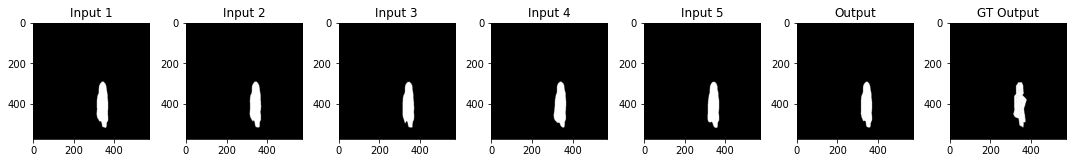

Max Value:  1  Min Value:  0
[1,  4000] loss: 0.322653
torch.Size([1, 572, 572])


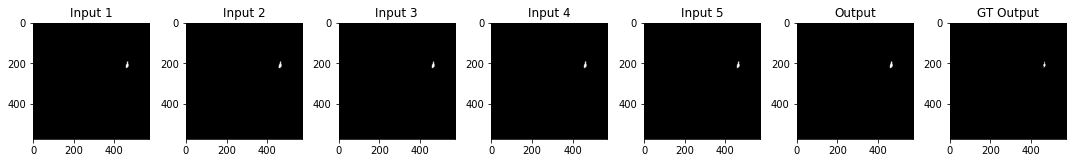

Max Value:  1  Min Value:  0
[1,  6000] loss: 0.322238
torch.Size([1, 572, 572])


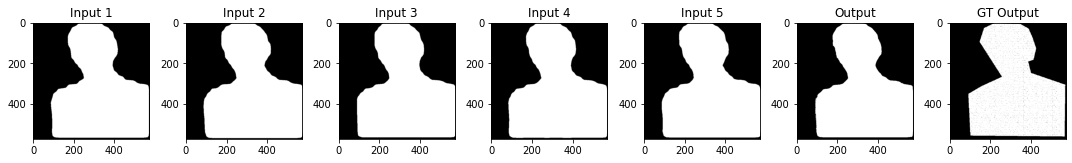

Max Value:  1  Min Value:  0
[1,  8000] loss: 0.320662
torch.Size([1, 572, 572])


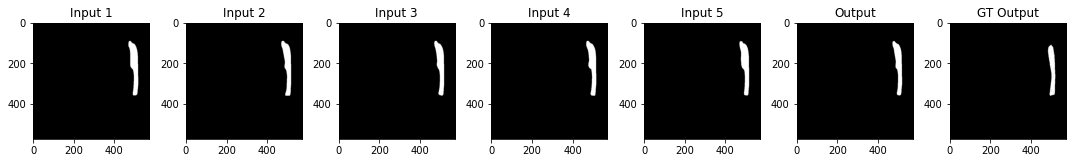

Max Value:  1  Min Value:  0
[2,  2000] loss: 0.321504
torch.Size([1, 572, 572])


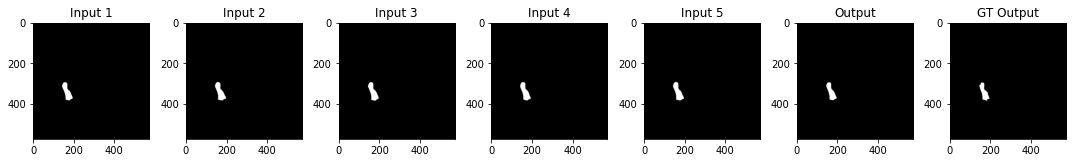

Max Value:  1  Min Value:  0
[2,  4000] loss: 0.321314
torch.Size([1, 572, 572])


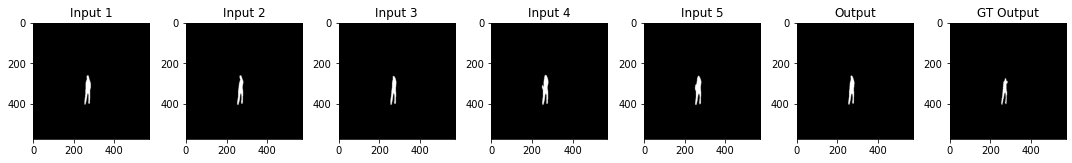

Max Value:  1  Min Value:  0
[2,  6000] loss: 0.320620
torch.Size([1, 572, 572])


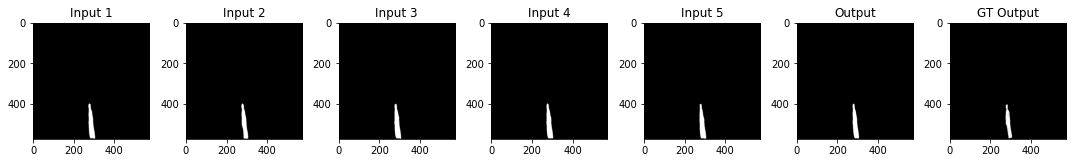

Max Value:  1  Min Value:  0
[2,  8000] loss: 0.320332
torch.Size([1, 572, 572])


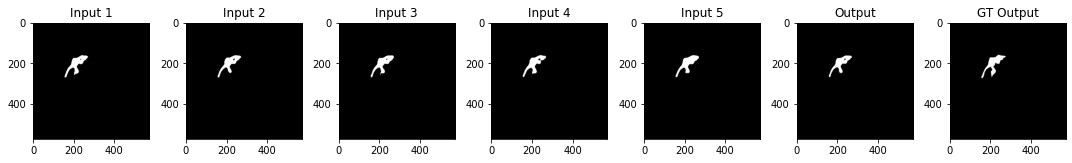

Max Value:  1  Min Value:  0
[3,  2000] loss: 0.320461
torch.Size([1, 572, 572])


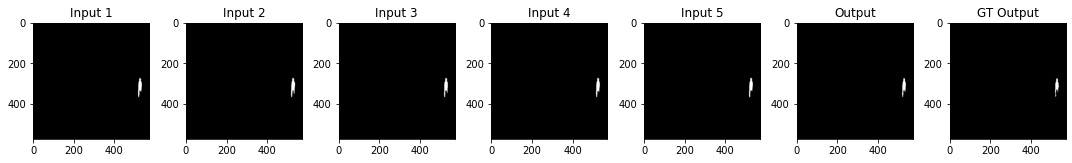

Max Value:  1  Min Value:  0
[3,  4000] loss: 0.320833
torch.Size([1, 572, 572])


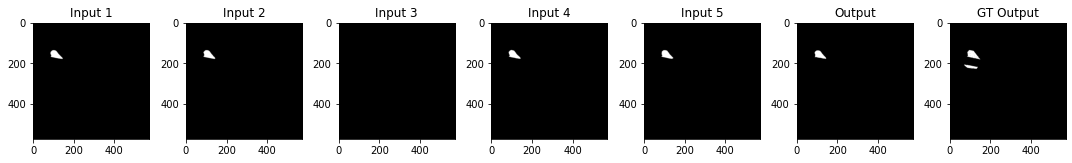

Max Value:  1  Min Value:  0
[3,  6000] loss: 0.320742
torch.Size([1, 572, 572])


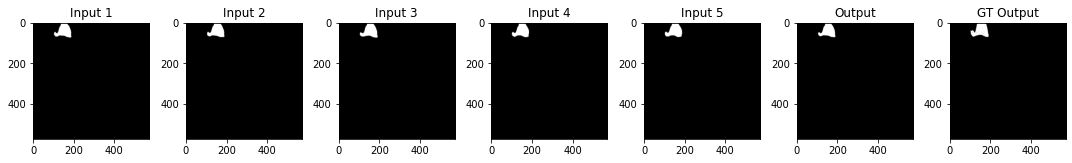

Max Value:  1  Min Value:  0
[3,  8000] loss: 0.321117
torch.Size([1, 572, 572])


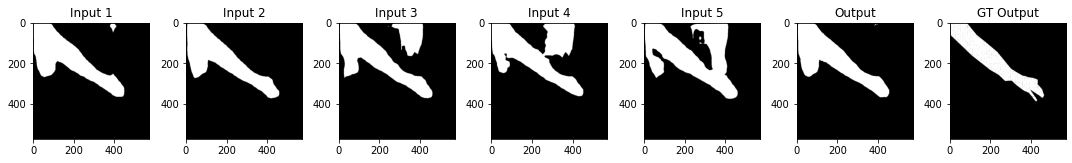

Max Value:  1  Min Value:  0
[4,  2000] loss: 0.320202
torch.Size([1, 572, 572])


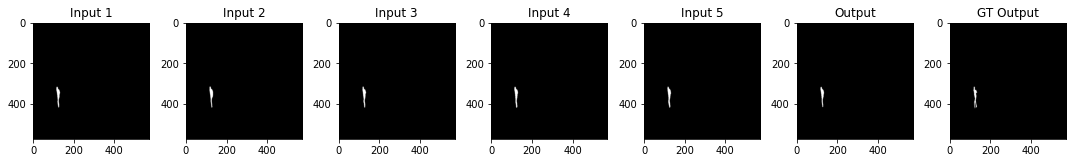

Max Value:  1  Min Value:  0
[4,  4000] loss: 0.321054
torch.Size([1, 572, 572])


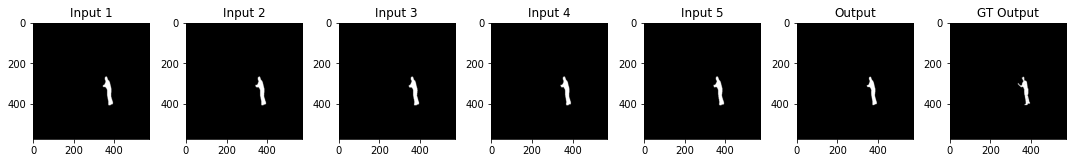

Max Value:  1  Min Value:  0
[4,  6000] loss: 0.320362
torch.Size([1, 572, 572])


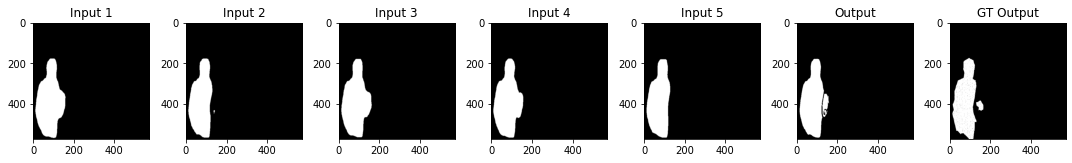

Max Value:  1  Min Value:  0
[4,  8000] loss: 0.320628
torch.Size([1, 572, 572])


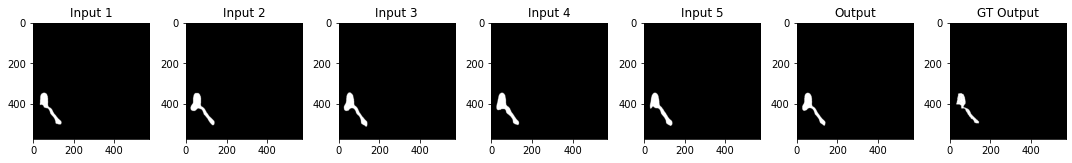

Max Value:  1  Min Value:  0
[5,  2000] loss: 0.321021
torch.Size([1, 572, 572])


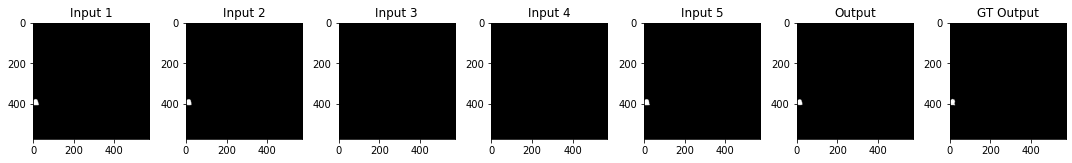

Max Value:  1  Min Value:  0
[5,  4000] loss: 0.320261
torch.Size([1, 572, 572])


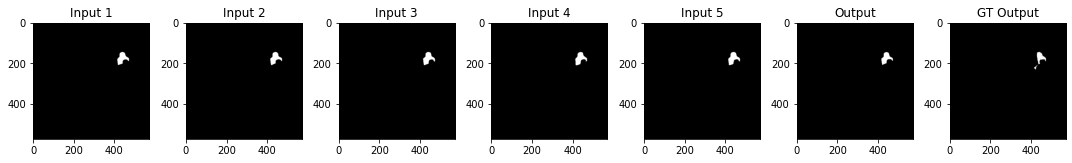

Max Value:  1  Min Value:  0
[5,  6000] loss: 0.320934
torch.Size([1, 572, 572])


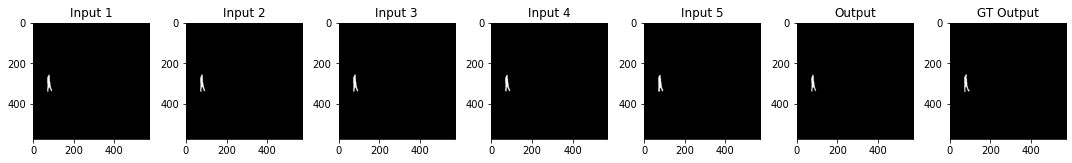

Max Value:  1  Min Value:  0
[5,  8000] loss: 0.320217
torch.Size([1, 572, 572])


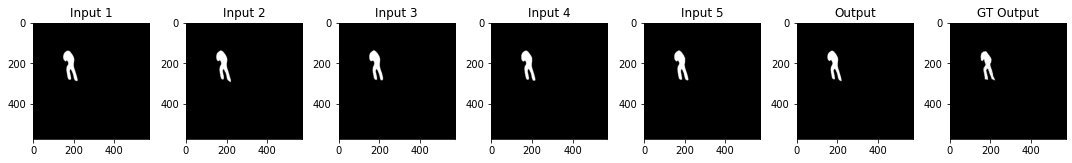

Max Value:  1  Min Value:  0
[6,  2000] loss: 0.320844
torch.Size([1, 572, 572])


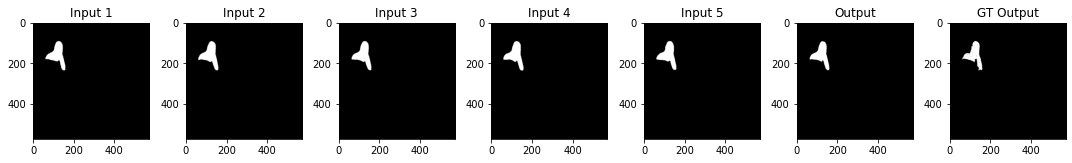

Max Value:  1  Min Value:  0
[6,  4000] loss: 0.320465
torch.Size([1, 572, 572])


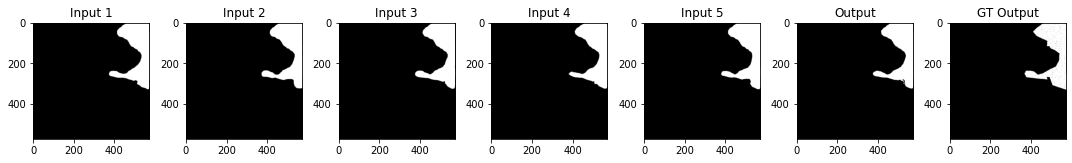

Max Value:  1  Min Value:  0
[6,  6000] loss: 0.320740
torch.Size([1, 572, 572])


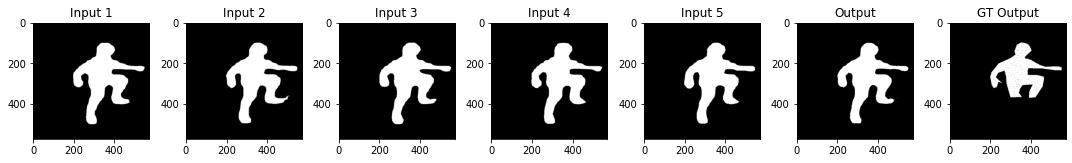

Max Value:  1  Min Value:  0
[6,  8000] loss: 0.320265
torch.Size([1, 572, 572])


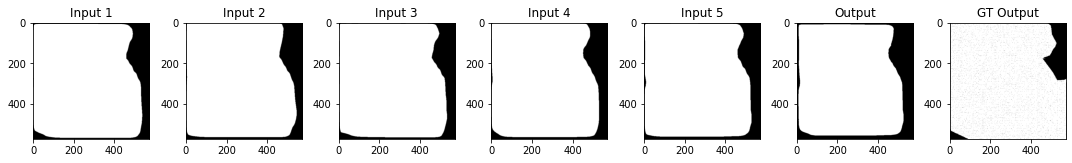

Max Value:  1  Min Value:  0
[7,  2000] loss: 0.320259
torch.Size([1, 572, 572])


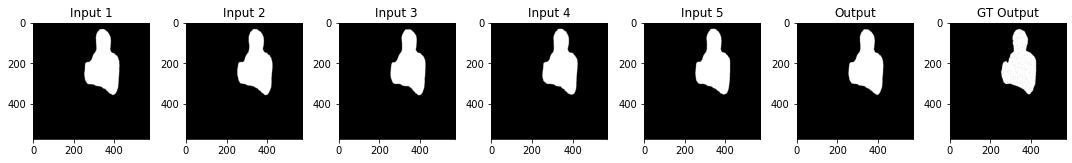

Max Value:  1  Min Value:  0
[7,  4000] loss: 0.320291
torch.Size([1, 572, 572])


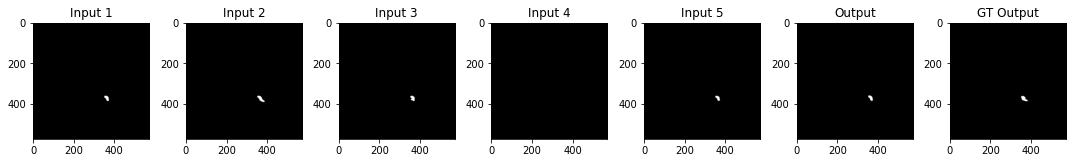

Max Value:  1  Min Value:  0
[7,  6000] loss: 0.321032
torch.Size([1, 572, 572])


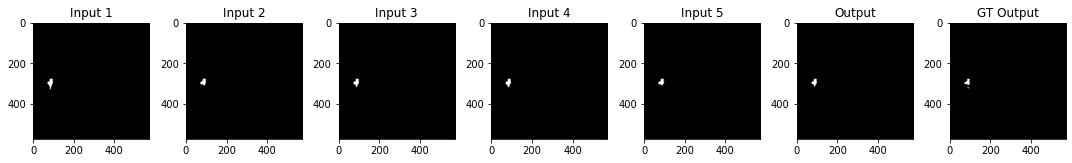

Max Value:  1  Min Value:  0
[7,  8000] loss: 0.320621
torch.Size([1, 572, 572])


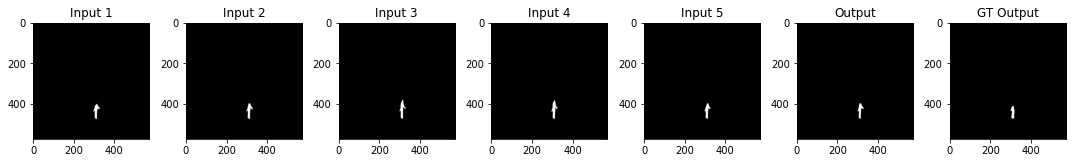

Max Value:  1  Min Value:  0
[8,  2000] loss: 0.320118
torch.Size([1, 572, 572])


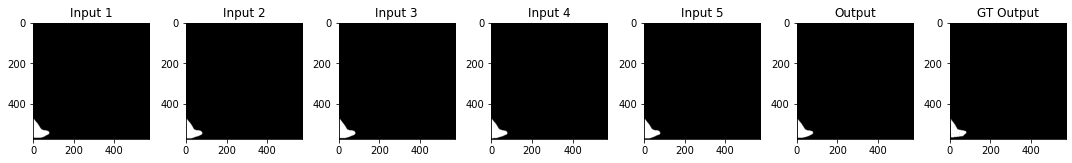

Max Value:  1  Min Value:  0
[8,  4000] loss: 0.320839
torch.Size([1, 572, 572])


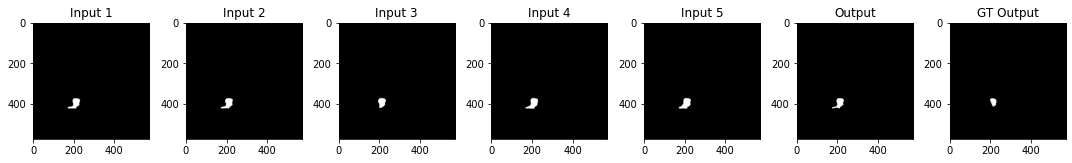

Max Value:  1  Min Value:  0
[8,  6000] loss: 0.320262
torch.Size([1, 572, 572])


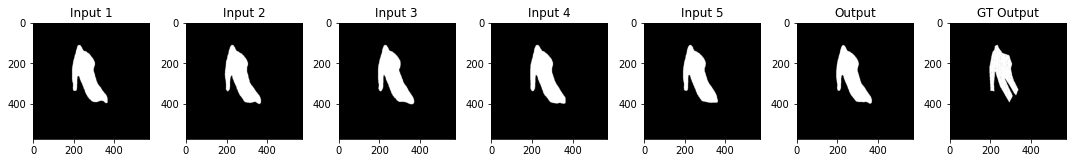

Max Value:  1  Min Value:  0
[8,  8000] loss: 0.320524
torch.Size([1, 572, 572])


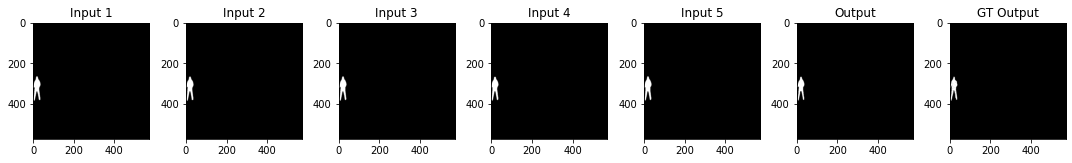

Max Value:  1  Min Value:  0
[9,  2000] loss: 0.320192
torch.Size([1, 572, 572])


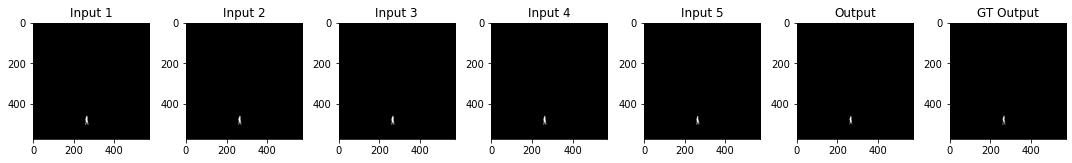

Max Value:  1  Min Value:  0
[9,  4000] loss: 0.320575
torch.Size([1, 572, 572])


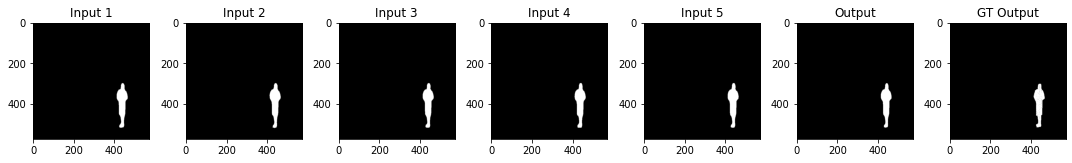

Max Value:  1  Min Value:  0
[9,  6000] loss: 0.320757
torch.Size([1, 572, 572])


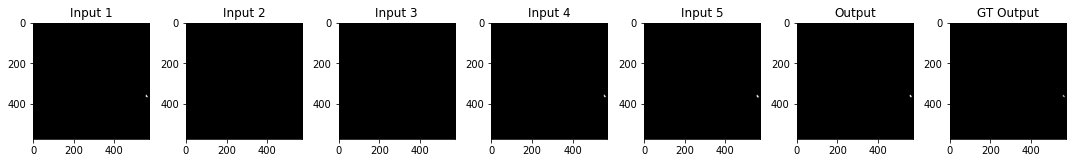

Max Value:  1  Min Value:  0
[9,  8000] loss: 0.320403
torch.Size([1, 572, 572])


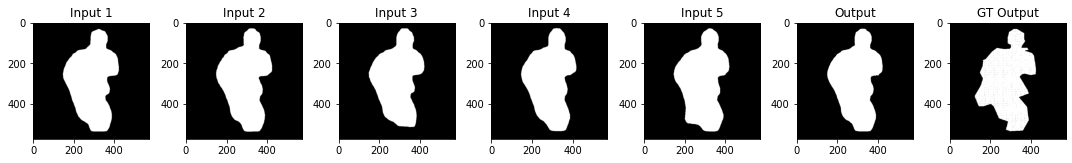

Max Value:  1  Min Value:  0
[10,  2000] loss: 0.320495
torch.Size([1, 572, 572])


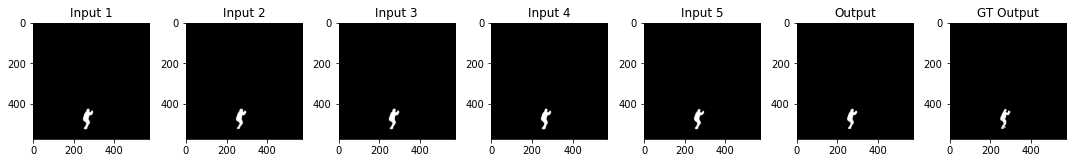

Max Value:  1  Min Value:  0
[10,  4000] loss: 0.320155
torch.Size([1, 572, 572])


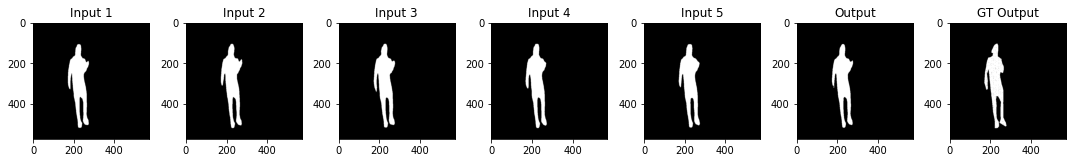

Max Value:  1  Min Value:  0
[10,  6000] loss: 0.320095
torch.Size([1, 572, 572])


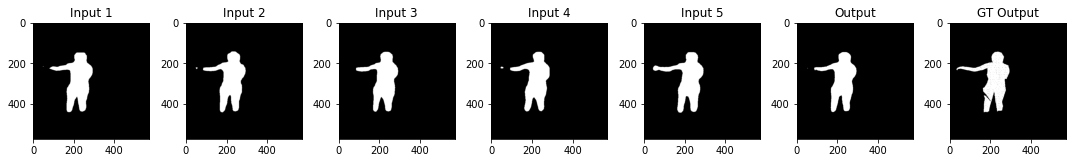

Max Value:  1  Min Value:  0
[10,  8000] loss: 0.320840
torch.Size([1, 572, 572])


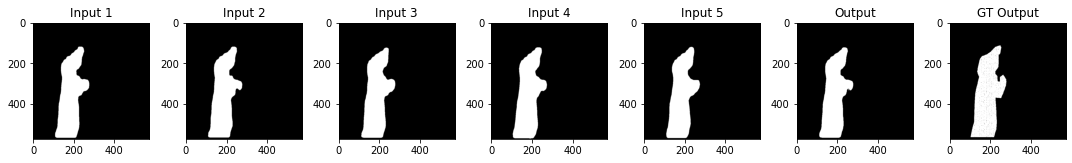

Max Value:  1  Min Value:  0
[11,  2000] loss: 0.319973
torch.Size([1, 572, 572])


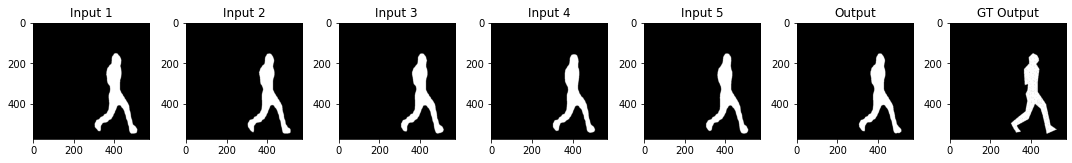

Max Value:  1  Min Value:  0
[11,  4000] loss: 0.320406
torch.Size([1, 572, 572])


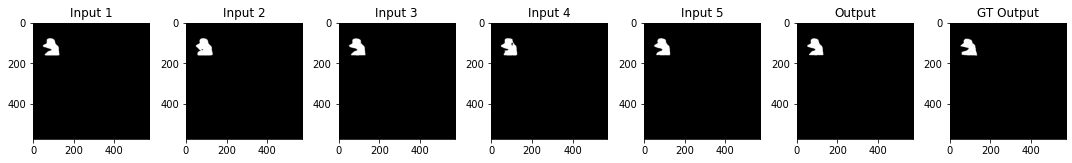

Max Value:  1  Min Value:  0
[11,  6000] loss: 0.320611
torch.Size([1, 572, 572])


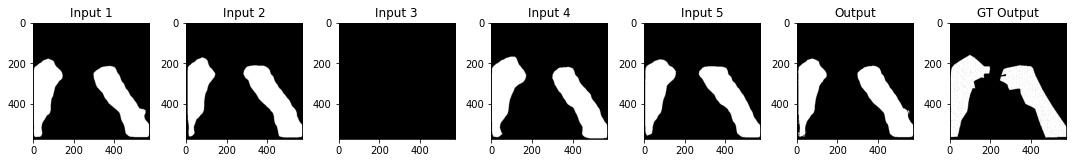

Max Value:  1  Min Value:  0
[11,  8000] loss: 0.320447
torch.Size([1, 572, 572])


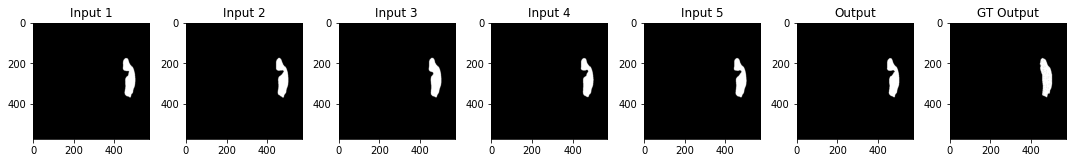

Max Value:  1  Min Value:  0
[12,  2000] loss: 0.321039
torch.Size([1, 572, 572])


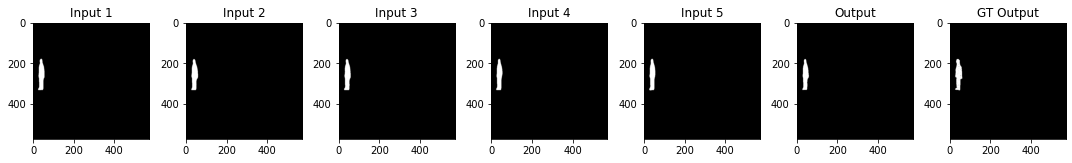

Max Value:  1  Min Value:  0
[12,  4000] loss: 0.319943
torch.Size([1, 572, 572])


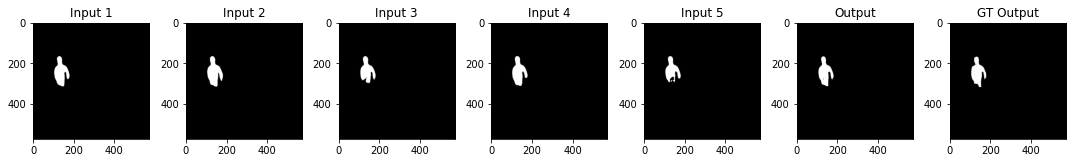

Max Value:  1  Min Value:  0
[12,  6000] loss: 0.320349
torch.Size([1, 572, 572])


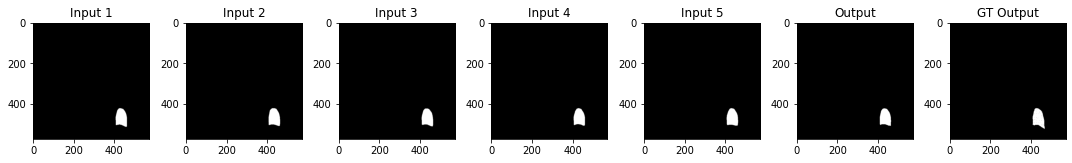

Max Value:  1  Min Value:  0
[12,  8000] loss: 0.320203
torch.Size([1, 572, 572])


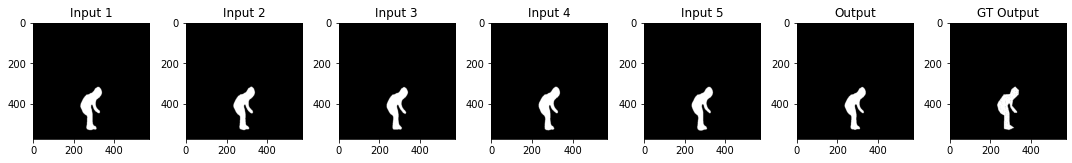

Max Value:  1  Min Value:  0
[13,  2000] loss: 0.320294
torch.Size([1, 572, 572])


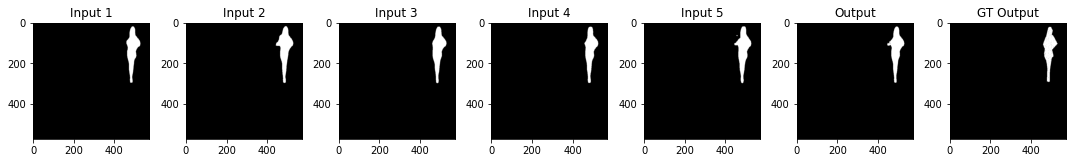

Max Value:  1  Min Value:  0
[13,  4000] loss: 0.320620
torch.Size([1, 572, 572])


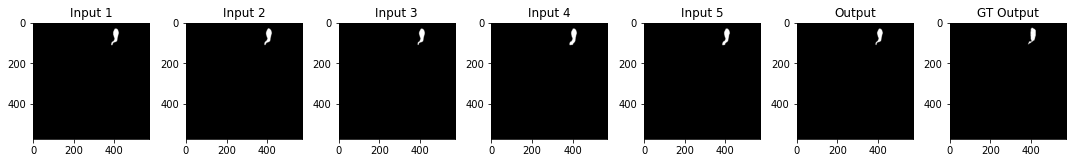

Max Value:  1  Min Value:  0
[13,  6000] loss: 0.319877
torch.Size([1, 572, 572])


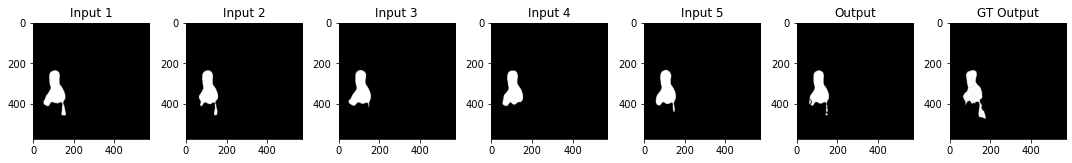

Max Value:  1  Min Value:  0
[13,  8000] loss: 0.320377
torch.Size([1, 572, 572])


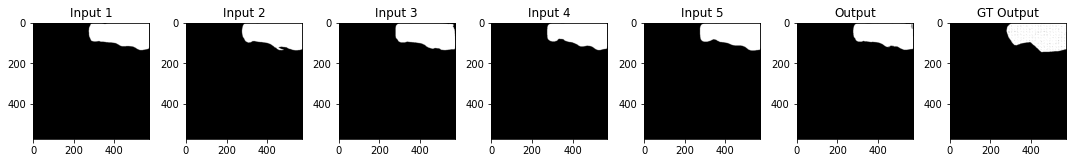

Max Value:  1  Min Value:  0
[14,  2000] loss: 0.320481
torch.Size([1, 572, 572])


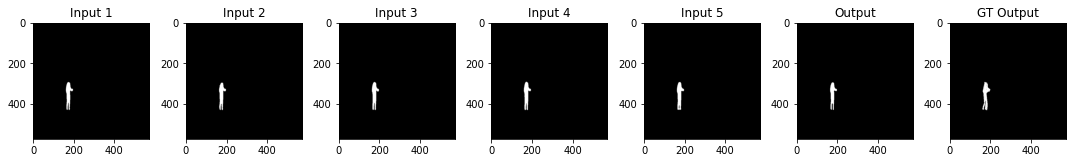

Max Value:  1  Min Value:  0
[14,  4000] loss: 0.320402
torch.Size([1, 572, 572])


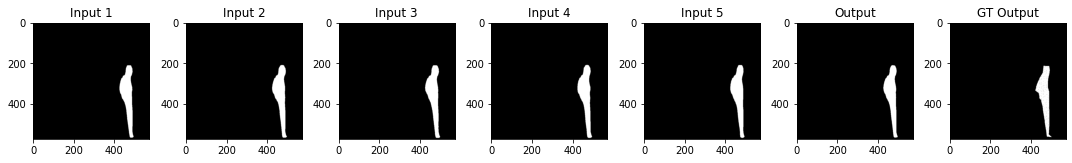

Max Value:  1  Min Value:  0
[14,  6000] loss: 0.320105
torch.Size([1, 572, 572])


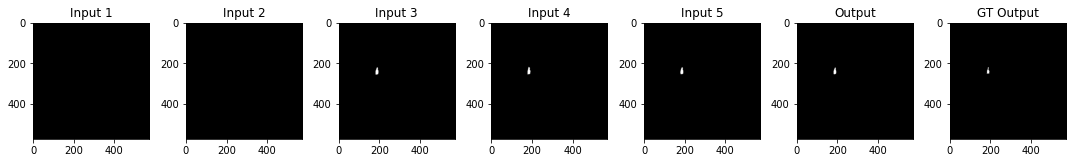

Max Value:  1  Min Value:  0
[14,  8000] loss: 0.320307
torch.Size([1, 572, 572])


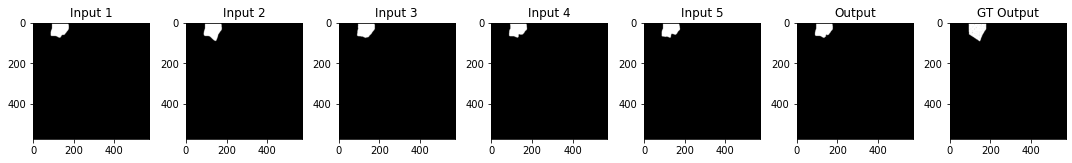

Max Value:  1  Min Value:  0
[15,  2000] loss: 0.320384
torch.Size([1, 572, 572])


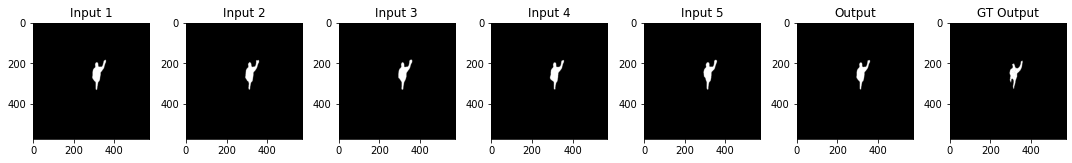

Max Value:  1  Min Value:  0
[15,  4000] loss: 0.320087
torch.Size([1, 572, 572])


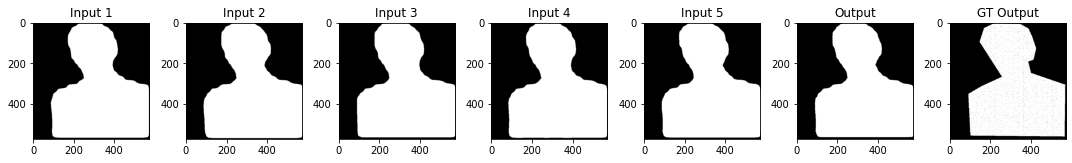

Max Value:  1  Min Value:  0
[15,  6000] loss: 0.320771
torch.Size([1, 572, 572])


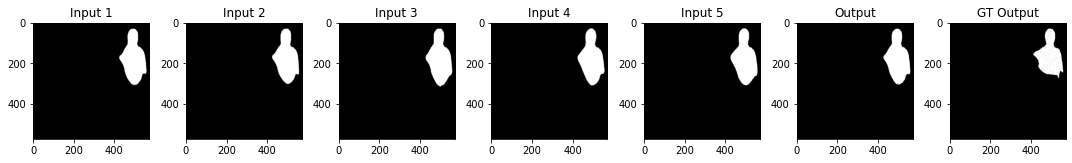

Max Value:  1  Min Value:  0
[15,  8000] loss: 0.320206
torch.Size([1, 572, 572])


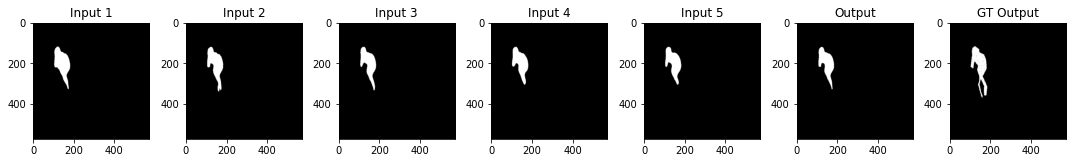

Max Value:  1  Min Value:  0
[16,  2000] loss: 0.320284
torch.Size([1, 572, 572])


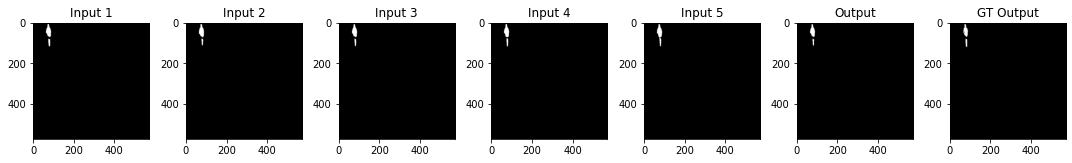

Max Value:  1  Min Value:  0
[16,  4000] loss: 0.319994
torch.Size([1, 572, 572])


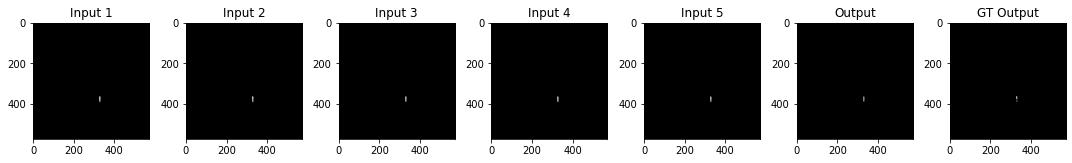

Max Value:  1  Min Value:  0
[16,  6000] loss: 0.320526
torch.Size([1, 572, 572])


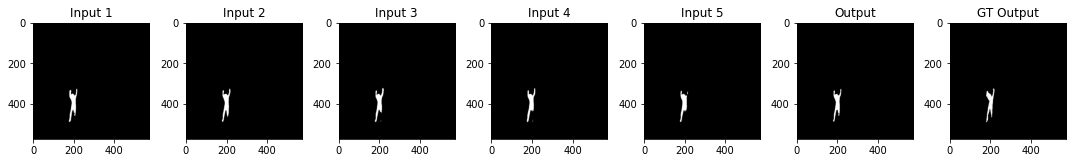

Max Value:  1  Min Value:  0
[16,  8000] loss: 0.320677
torch.Size([1, 572, 572])


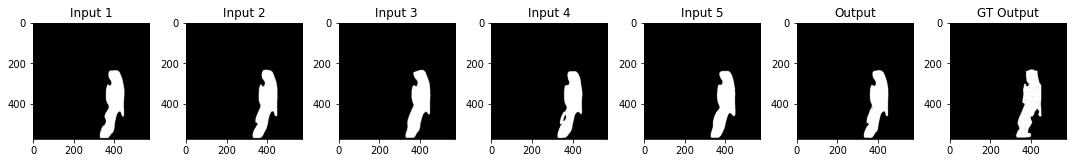

Max Value:  1  Min Value:  0
[17,  2000] loss: 0.320040
torch.Size([1, 572, 572])


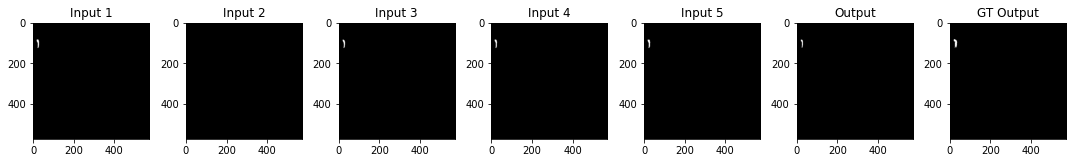

Max Value:  1  Min Value:  0
[17,  4000] loss: 0.320229
torch.Size([1, 572, 572])


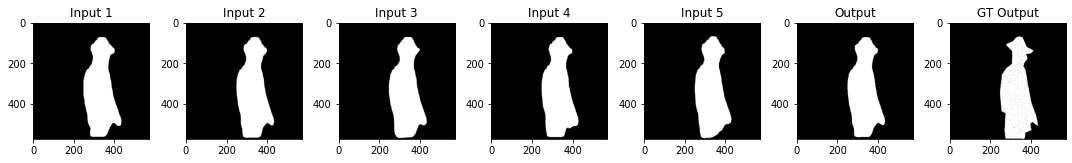

Max Value:  1  Min Value:  0
[17,  6000] loss: 0.320294
torch.Size([1, 572, 572])


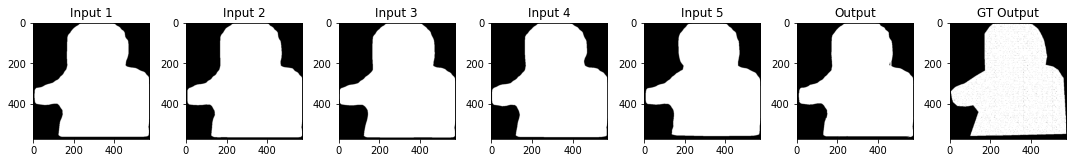

Max Value:  1  Min Value:  0
[17,  8000] loss: 0.320864
torch.Size([1, 572, 572])


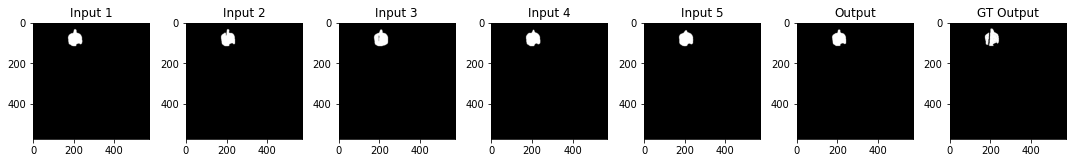

Max Value:  1  Min Value:  0
[18,  2000] loss: 0.320352
torch.Size([1, 572, 572])


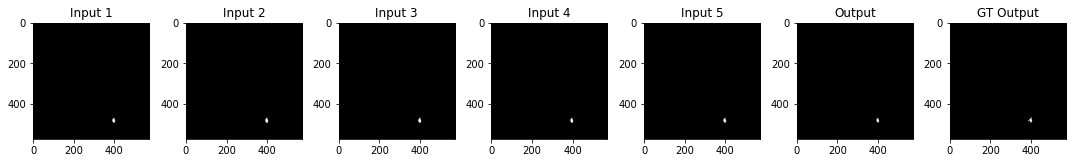

Max Value:  1  Min Value:  0
[18,  4000] loss: 0.319925
torch.Size([1, 572, 572])


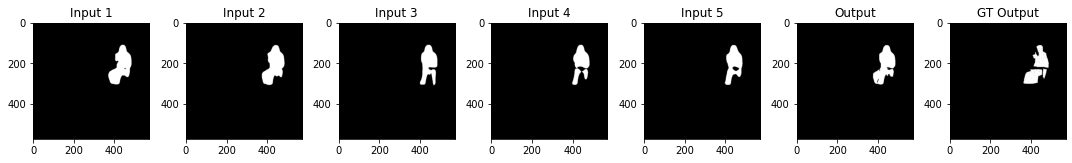

Max Value:  1  Min Value:  0
[18,  6000] loss: 0.320309
torch.Size([1, 572, 572])


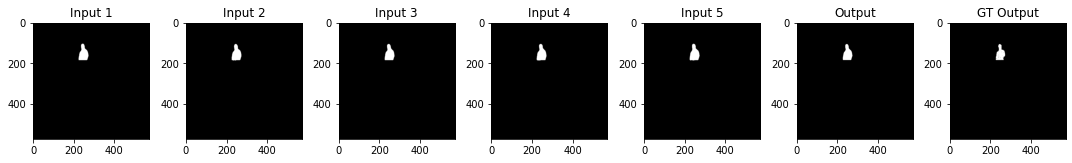

Max Value:  1  Min Value:  0
[18,  8000] loss: 0.320460
torch.Size([1, 572, 572])


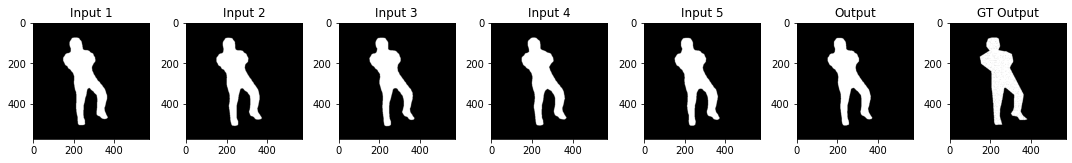

Max Value:  1  Min Value:  0
[19,  2000] loss: 0.320344
torch.Size([1, 572, 572])


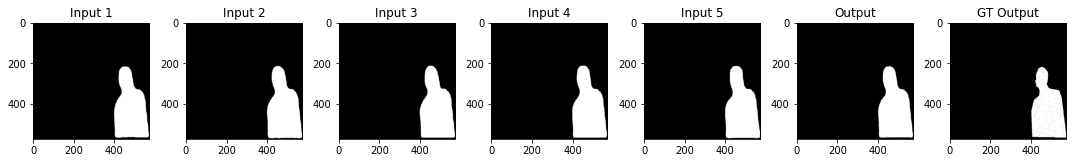

Max Value:  1  Min Value:  0
[19,  4000] loss: 0.320340
torch.Size([1, 572, 572])


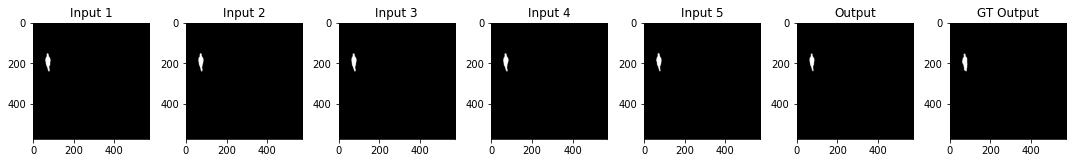

Max Value:  1  Min Value:  0
[19,  6000] loss: 0.319812
torch.Size([1, 572, 572])


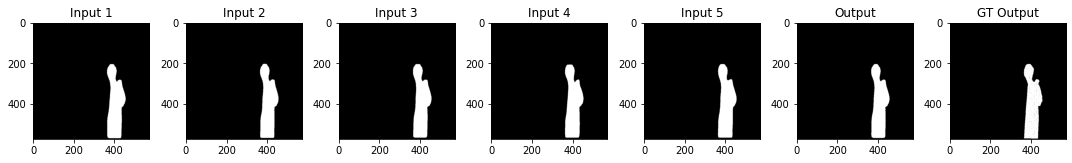

Max Value:  1  Min Value:  0
[19,  8000] loss: 0.320490
torch.Size([1, 572, 572])


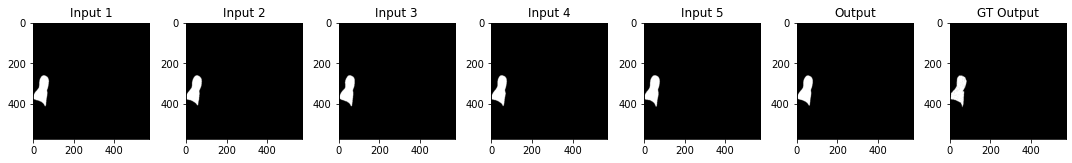

Max Value:  1  Min Value:  0
[20,  2000] loss: 0.320596
torch.Size([1, 572, 572])


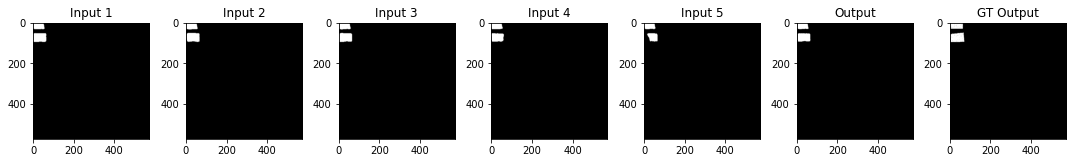

Max Value:  1  Min Value:  0
[20,  4000] loss: 0.319822
torch.Size([1, 572, 572])


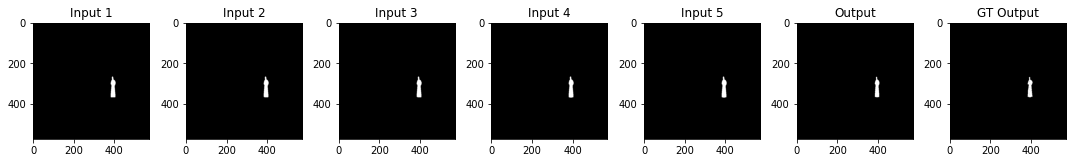

Max Value:  1  Min Value:  0
[20,  6000] loss: 0.320528
torch.Size([1, 572, 572])


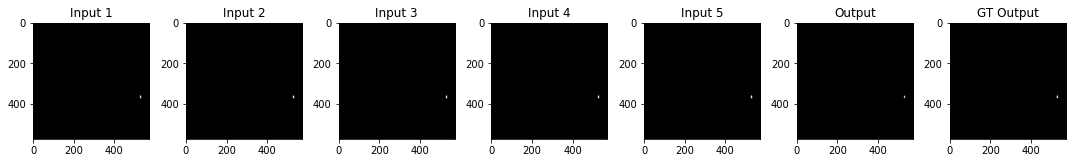

Max Value:  1  Min Value:  0
[20,  8000] loss: 0.320288
torch.Size([1, 572, 572])


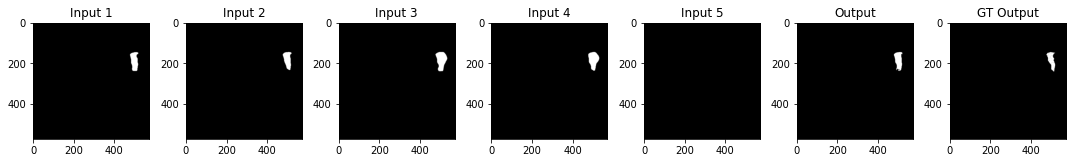

Max Value:  1  Min Value:  0
[21,  2000] loss: 0.320515
torch.Size([1, 572, 572])


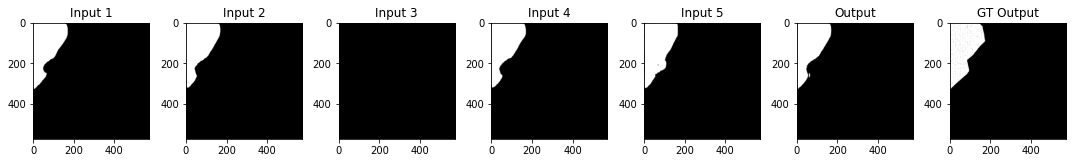

Max Value:  1  Min Value:  0
[21,  4000] loss: 0.319892
torch.Size([1, 572, 572])


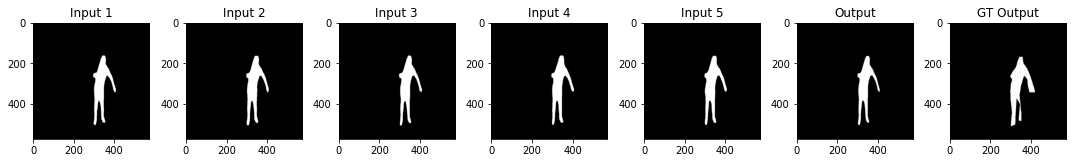

Max Value:  1  Min Value:  0
[21,  6000] loss: 0.320358
torch.Size([1, 572, 572])


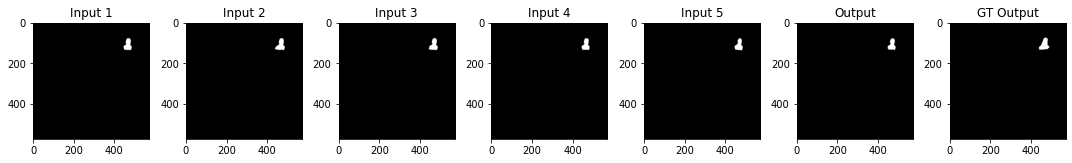

Max Value:  1  Min Value:  0
[21,  8000] loss: 0.320412
torch.Size([1, 572, 572])


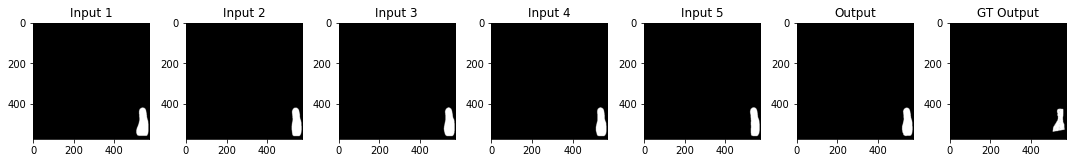

Max Value:  1  Min Value:  0
[22,  2000] loss: 0.320686
torch.Size([1, 572, 572])


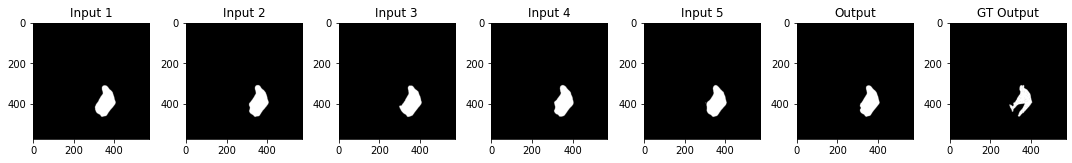

Max Value:  1  Min Value:  0
[22,  4000] loss: 0.319663
torch.Size([1, 572, 572])


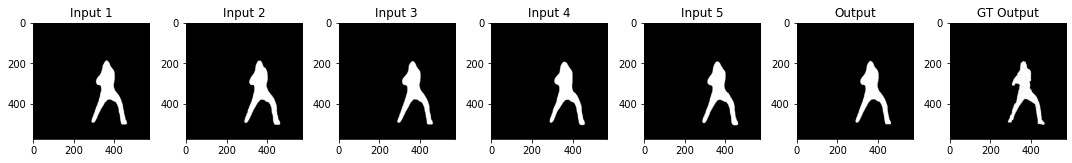

Max Value:  1  Min Value:  0
[22,  6000] loss: 0.320437
torch.Size([1, 572, 572])


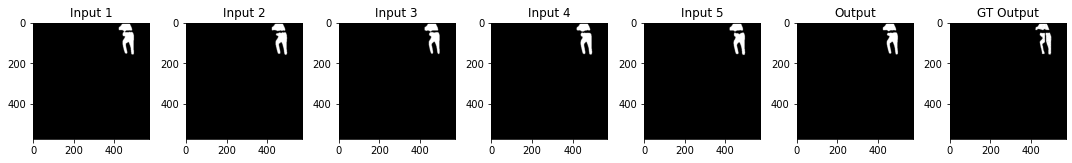

Max Value:  1  Min Value:  0
[22,  8000] loss: 0.320337
torch.Size([1, 572, 572])


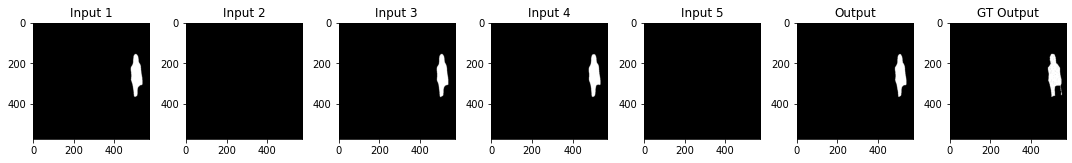

Max Value:  1  Min Value:  0
[23,  2000] loss: 0.320345
torch.Size([1, 572, 572])


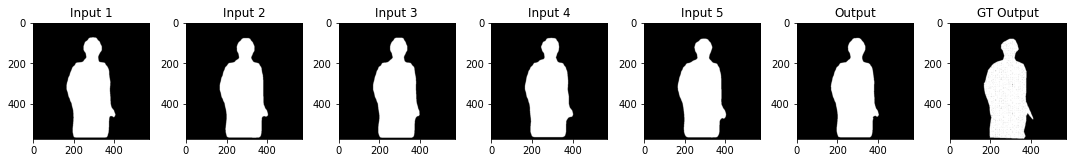

Max Value:  1  Min Value:  0
[23,  4000] loss: 0.320615
torch.Size([1, 572, 572])


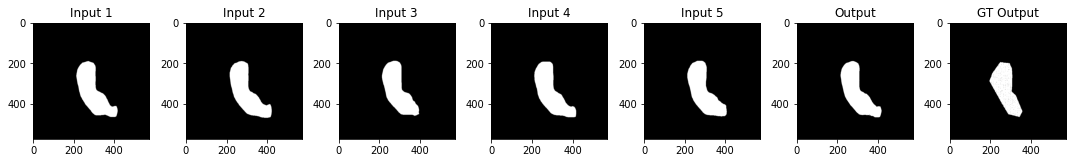

Max Value:  1  Min Value:  0
[23,  6000] loss: 0.319793
torch.Size([1, 572, 572])


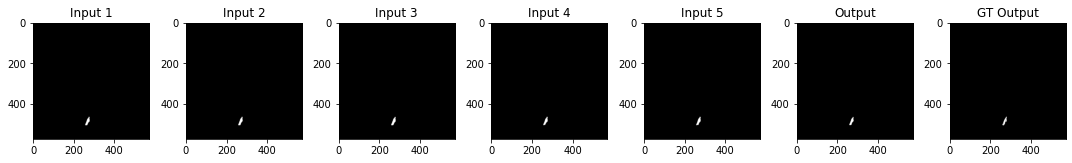

Max Value:  1  Min Value:  0
[23,  8000] loss: 0.320158
torch.Size([1, 572, 572])


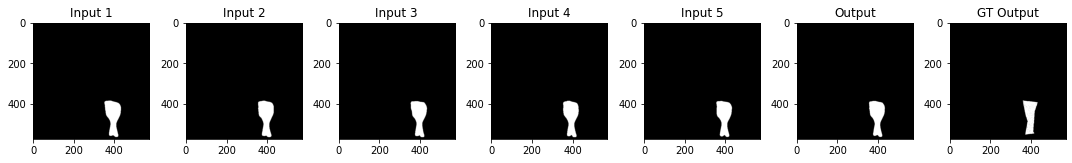

Max Value:  1  Min Value:  0
[24,  2000] loss: 0.319751
torch.Size([1, 572, 572])


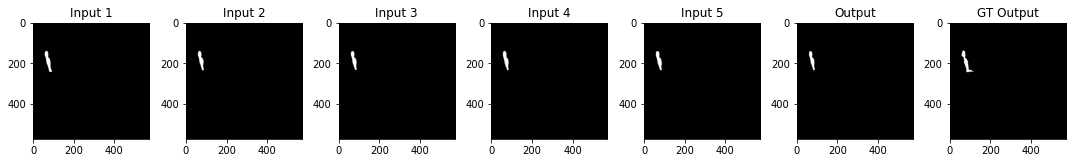

Max Value:  1  Min Value:  0
[24,  4000] loss: 0.320576
torch.Size([1, 572, 572])


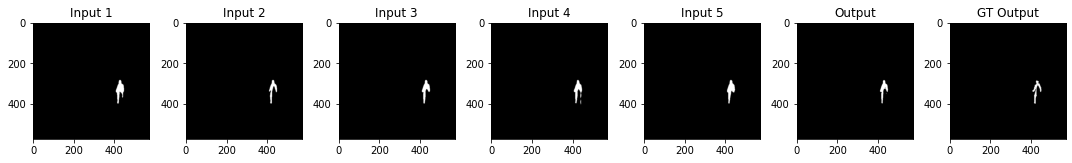

Max Value:  1  Min Value:  0
[24,  6000] loss: 0.320519
torch.Size([1, 572, 572])


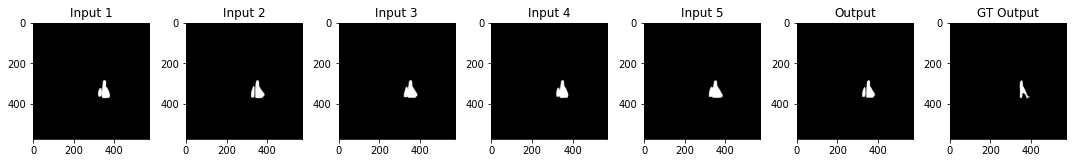

Max Value:  1  Min Value:  0
[24,  8000] loss: 0.320134
torch.Size([1, 572, 572])


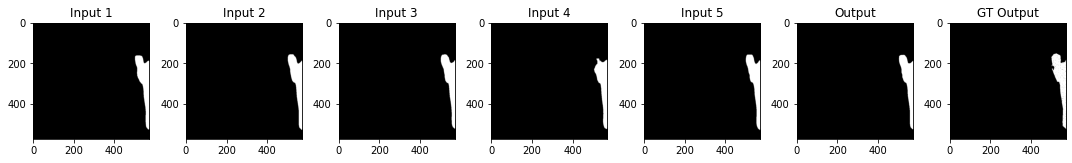

Max Value:  1  Min Value:  0
[25,  2000] loss: 0.320282
torch.Size([1, 572, 572])


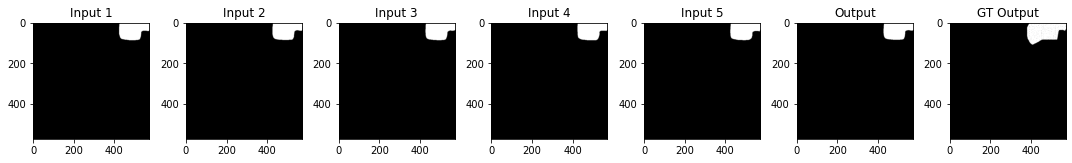

Max Value:  1  Min Value:  0
[25,  4000] loss: 0.320070
torch.Size([1, 572, 572])


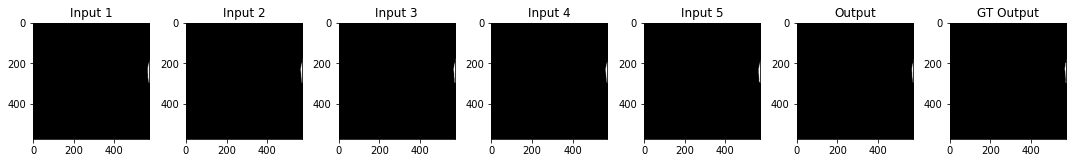

Max Value:  1  Min Value:  0
[25,  6000] loss: 0.320674
torch.Size([1, 572, 572])


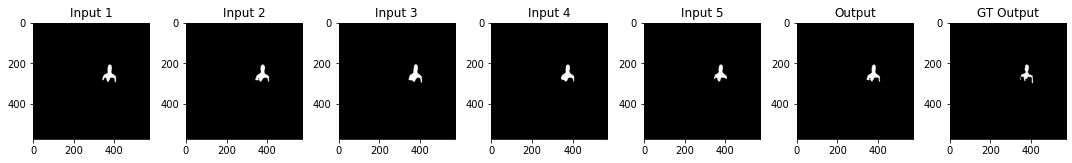

Max Value:  1  Min Value:  0
[25,  8000] loss: 0.320018
torch.Size([1, 572, 572])


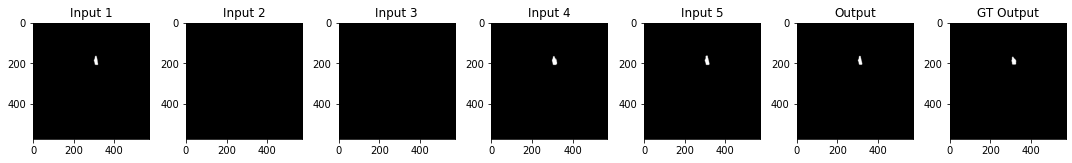

Max Value:  1  Min Value:  0
[26,  2000] loss: 0.320446
torch.Size([1, 572, 572])


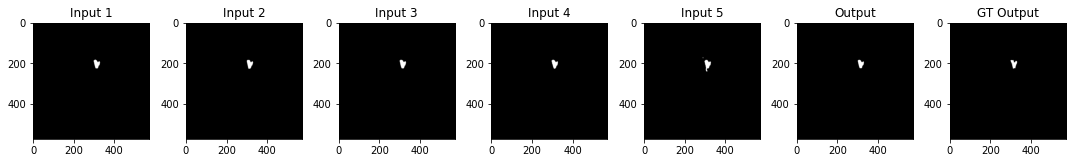

Max Value:  1  Min Value:  0
[26,  4000] loss: 0.320015
torch.Size([1, 572, 572])


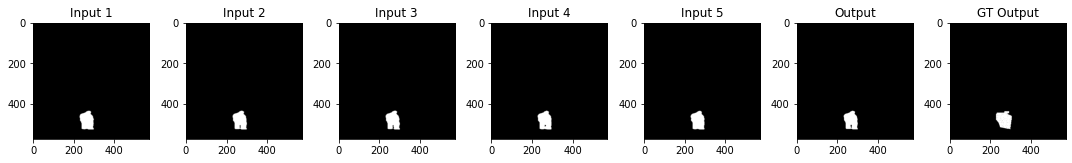

Max Value:  1  Min Value:  0
[26,  6000] loss: 0.320657
torch.Size([1, 572, 572])


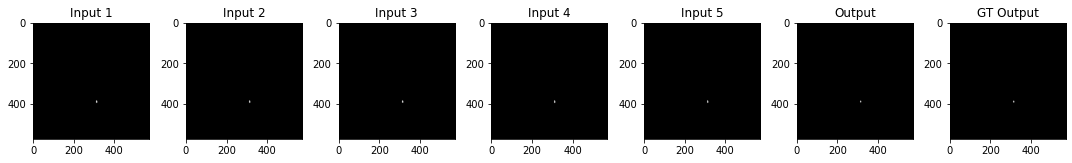

Max Value:  1  Min Value:  0
[26,  8000] loss: 0.320080
torch.Size([1, 572, 572])


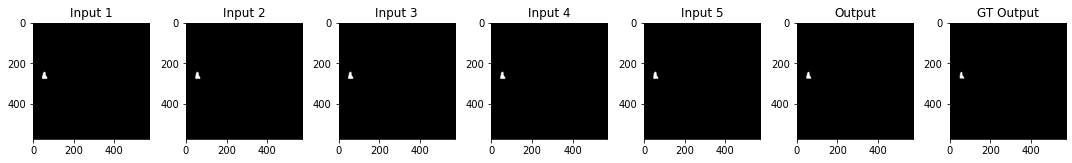

Max Value:  1  Min Value:  0
[27,  2000] loss: 0.319711
torch.Size([1, 572, 572])


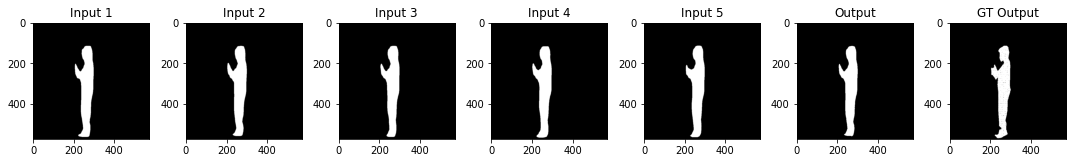

Max Value:  1  Min Value:  0
[27,  4000] loss: 0.320216
torch.Size([1, 572, 572])


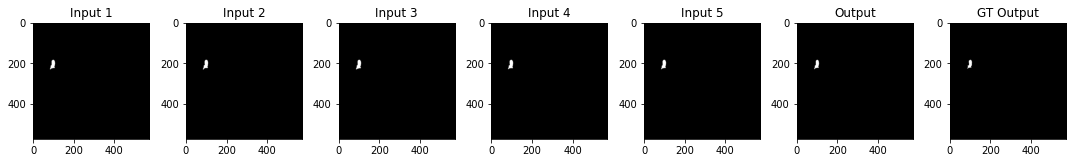

Max Value:  1  Min Value:  0
[27,  6000] loss: 0.320566
torch.Size([1, 572, 572])


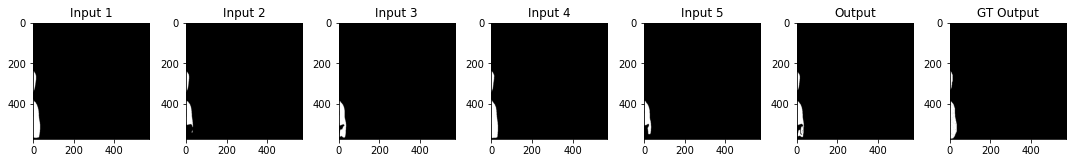

Max Value:  1  Min Value:  0
[27,  8000] loss: 0.320403
torch.Size([1, 572, 572])


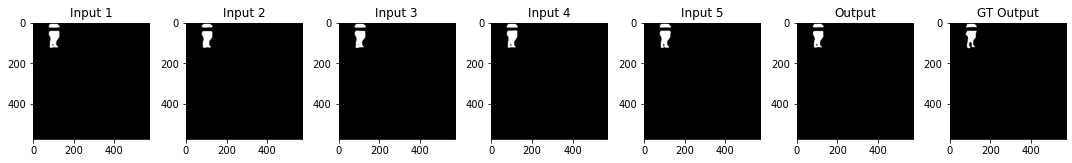

Max Value:  1  Min Value:  0
[28,  2000] loss: 0.320370
torch.Size([1, 572, 572])


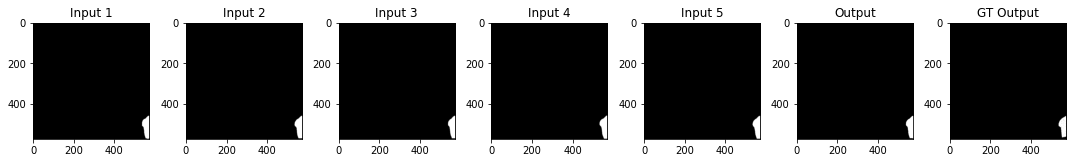

Max Value:  1  Min Value:  0
[28,  4000] loss: 0.319986
torch.Size([1, 572, 572])


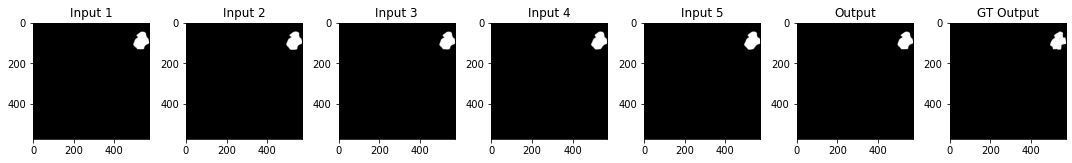

Max Value:  1  Min Value:  0
[28,  6000] loss: 0.320356
torch.Size([1, 572, 572])


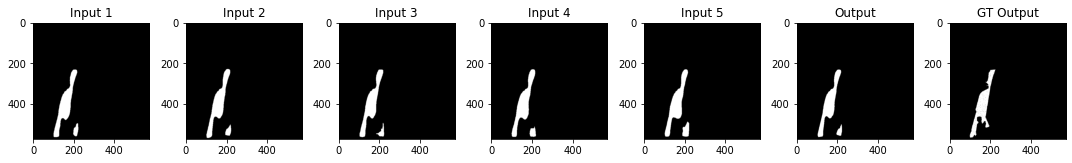

Max Value:  1  Min Value:  0
[28,  8000] loss: 0.320303
torch.Size([1, 572, 572])


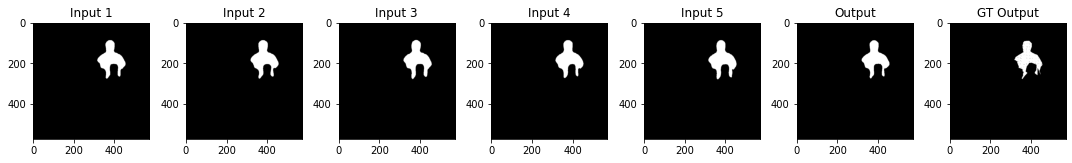

Max Value:  1  Min Value:  0
[29,  2000] loss: 0.320277
torch.Size([1, 572, 572])


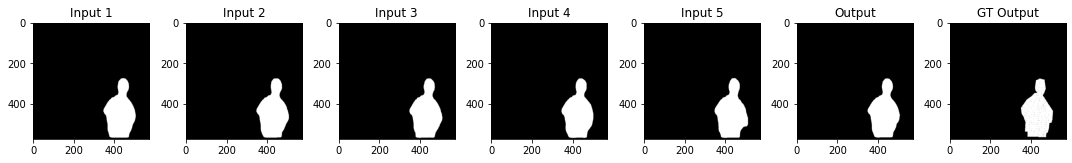

Max Value:  1  Min Value:  0
[29,  4000] loss: 0.320250
torch.Size([1, 572, 572])


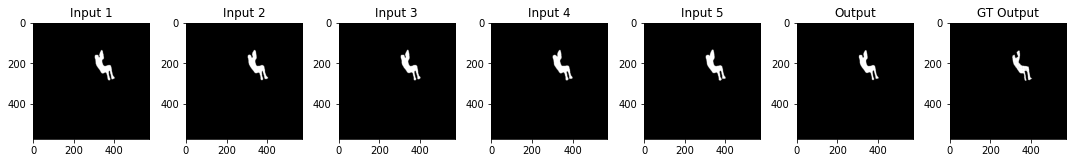

Max Value:  1  Min Value:  0
[29,  6000] loss: 0.320178
torch.Size([1, 572, 572])


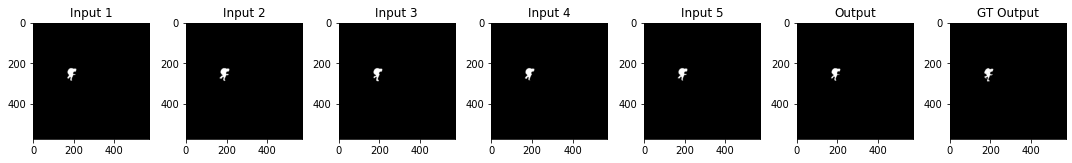

Max Value:  1  Min Value:  0
[29,  8000] loss: 0.320133
torch.Size([1, 572, 572])


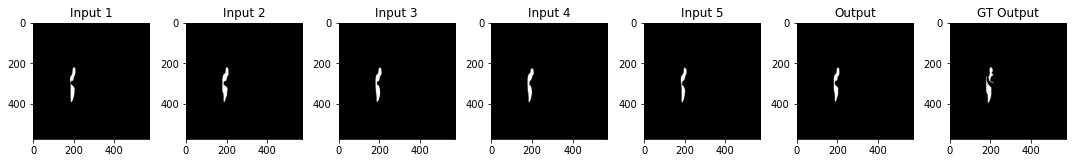

Max Value:  1  Min Value:  0
[30,  2000] loss: 0.320163
torch.Size([1, 572, 572])


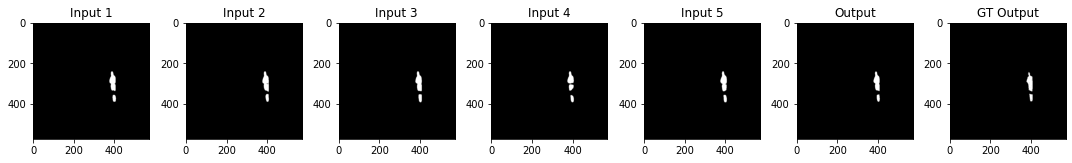

Max Value:  1  Min Value:  0
[30,  4000] loss: 0.320382
torch.Size([1, 572, 572])


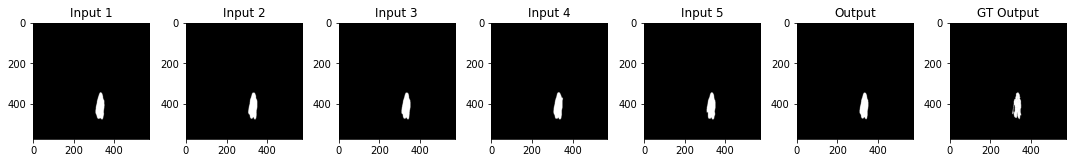

Max Value:  1  Min Value:  0
[30,  6000] loss: 0.320435
torch.Size([1, 572, 572])


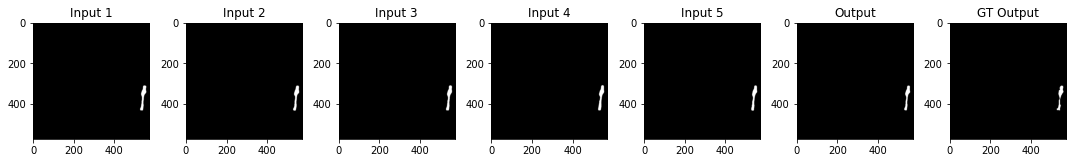

Max Value:  1  Min Value:  0
[30,  8000] loss: 0.320027
torch.Size([1, 572, 572])


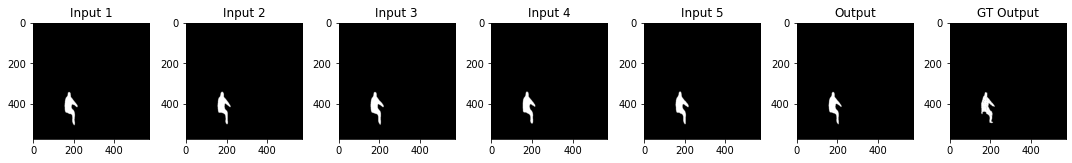

Max Value:  1  Min Value:  0
[31,  2000] loss: 0.320306
torch.Size([1, 572, 572])


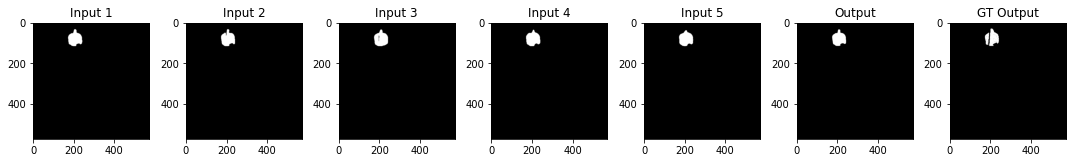

Max Value:  1  Min Value:  0
[31,  4000] loss: 0.320197
torch.Size([1, 572, 572])


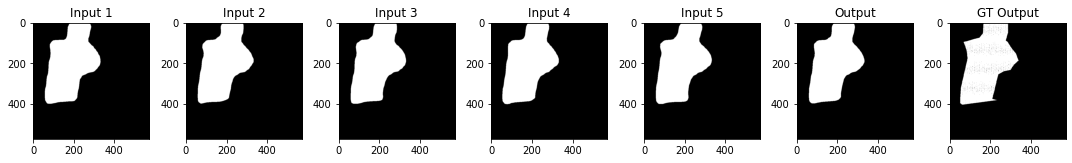

Max Value:  1  Min Value:  0
[31,  6000] loss: 0.319790
torch.Size([1, 572, 572])


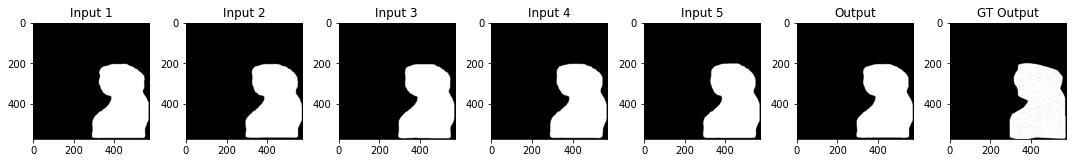

Max Value:  1  Min Value:  0
[31,  8000] loss: 0.320519
torch.Size([1, 572, 572])


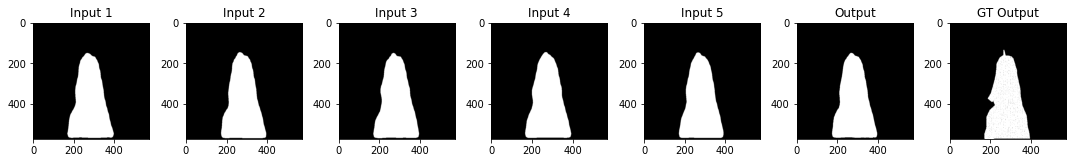

Max Value:  1  Min Value:  0
[32,  2000] loss: 0.320317
torch.Size([1, 572, 572])


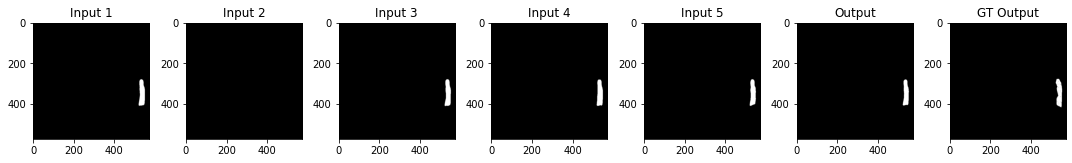

Max Value:  1  Min Value:  0
[32,  4000] loss: 0.320500
torch.Size([1, 572, 572])


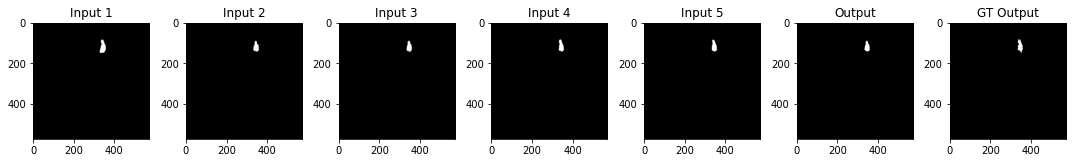

Max Value:  1  Min Value:  0
[32,  6000] loss: 0.320460
torch.Size([1, 572, 572])


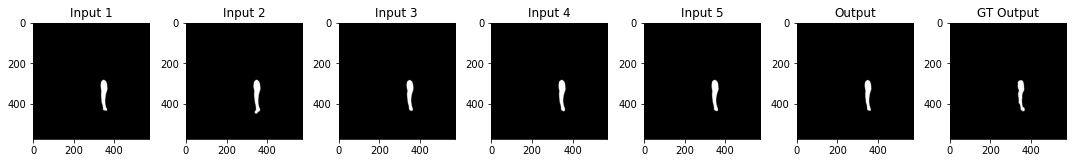

Max Value:  1  Min Value:  0
[32,  8000] loss: 0.319751
torch.Size([1, 572, 572])


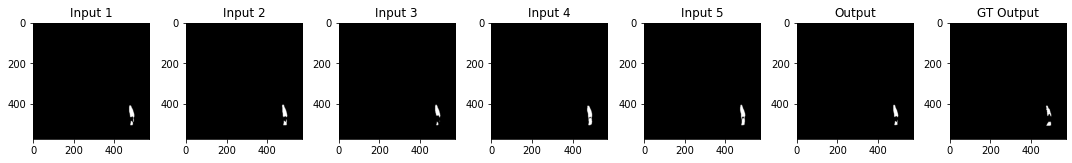

Max Value:  1  Min Value:  0
[33,  2000] loss: 0.319583
torch.Size([1, 572, 572])


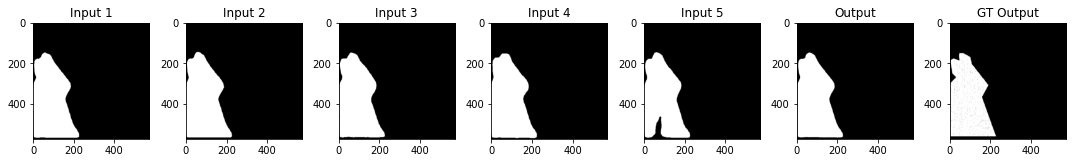

Max Value:  1  Min Value:  0
[33,  4000] loss: 0.320527
torch.Size([1, 572, 572])


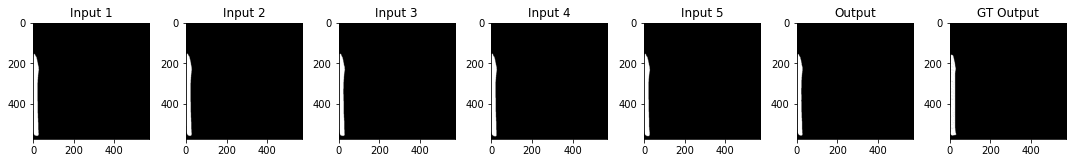

Max Value:  1  Min Value:  0
[33,  6000] loss: 0.320233
torch.Size([1, 572, 572])


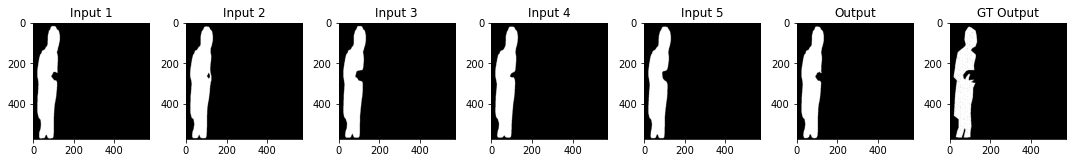

Max Value:  1  Min Value:  0
[33,  8000] loss: 0.320649
torch.Size([1, 572, 572])


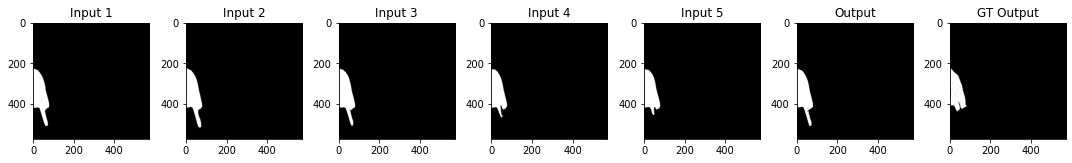

Max Value:  1  Min Value:  0
[34,  2000] loss: 0.320411
torch.Size([1, 572, 572])


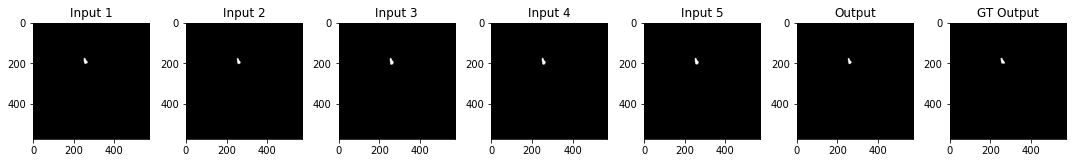

Max Value:  1  Min Value:  0
[34,  4000] loss: 0.320206
torch.Size([1, 572, 572])


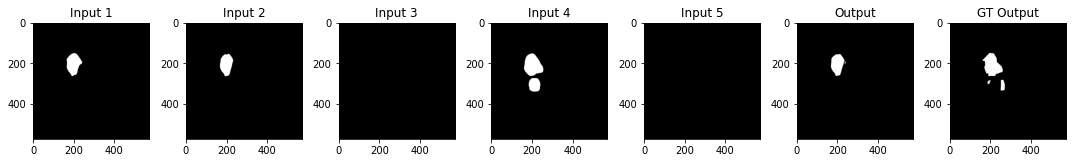

Max Value:  1  Min Value:  0
[34,  6000] loss: 0.320306
torch.Size([1, 572, 572])


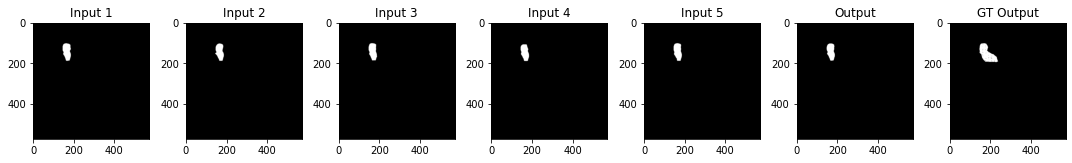

Max Value:  1  Min Value:  0
[34,  8000] loss: 0.320267
torch.Size([1, 572, 572])


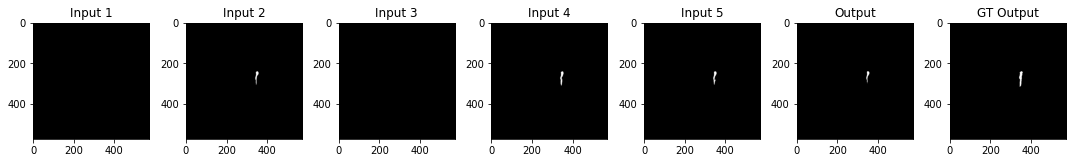

Max Value:  1  Min Value:  0
[35,  2000] loss: 0.319895
torch.Size([1, 572, 572])


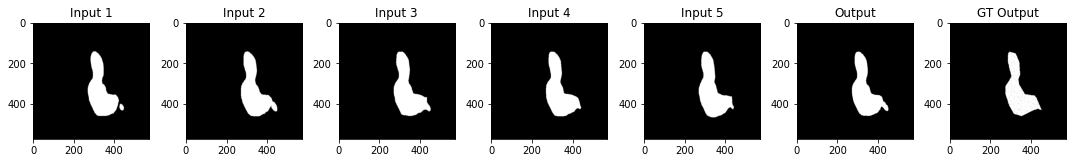

Max Value:  1  Min Value:  0
[35,  4000] loss: 0.320594
torch.Size([1, 572, 572])


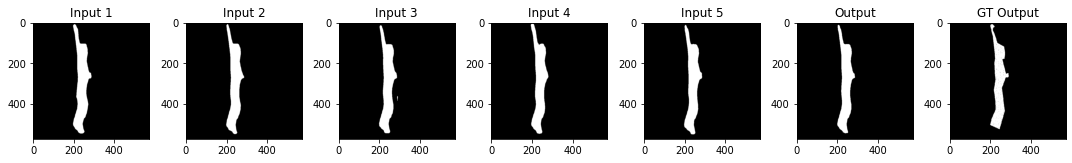

Max Value:  1  Min Value:  0
[35,  6000] loss: 0.319933
torch.Size([1, 572, 572])


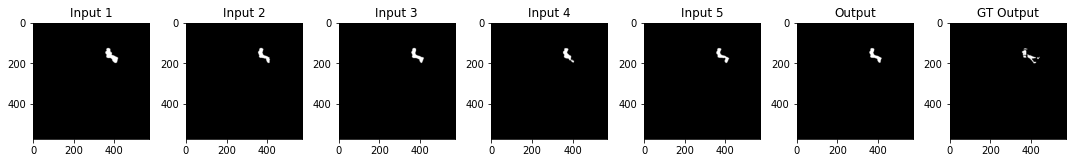

Max Value:  1  Min Value:  0
[35,  8000] loss: 0.320527
torch.Size([1, 572, 572])


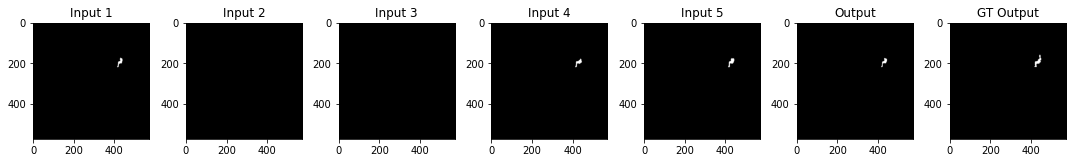

Max Value:  1  Min Value:  0
[36,  2000] loss: 0.320333
torch.Size([1, 572, 572])


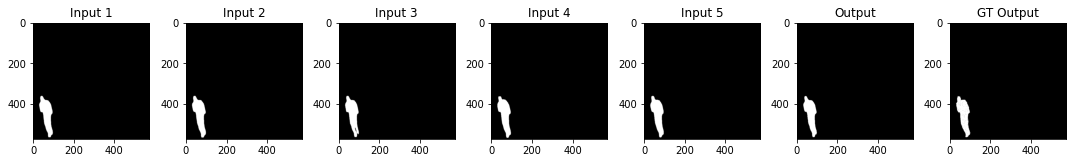

Max Value:  1  Min Value:  0
[36,  4000] loss: 0.320256
torch.Size([1, 572, 572])


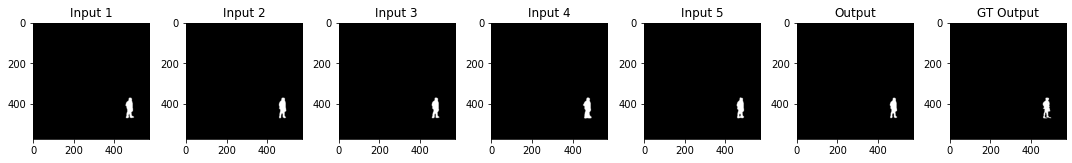

Max Value:  1  Min Value:  0
[36,  6000] loss: 0.319986
torch.Size([1, 572, 572])


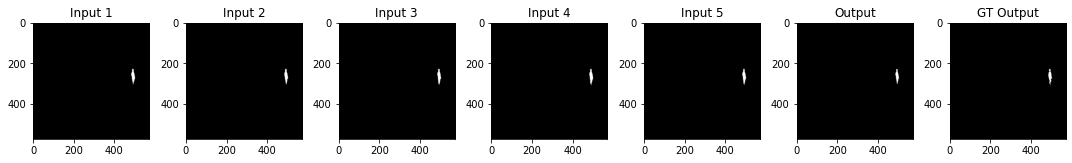

Max Value:  1  Min Value:  0
[36,  8000] loss: 0.320499
torch.Size([1, 572, 572])


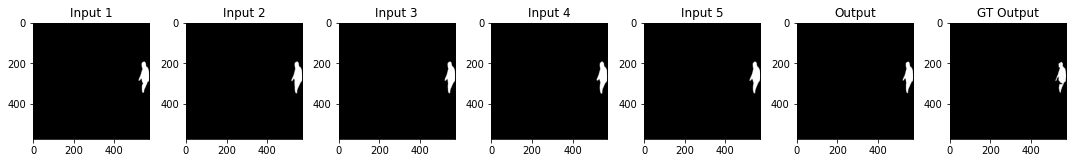

Max Value:  1  Min Value:  0
[37,  2000] loss: 0.320223
torch.Size([1, 572, 572])


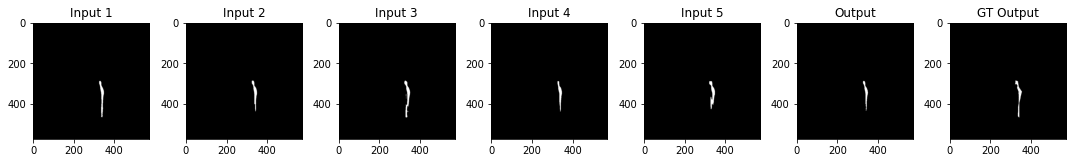

Max Value:  1  Min Value:  0
[37,  4000] loss: 0.320126
torch.Size([1, 572, 572])


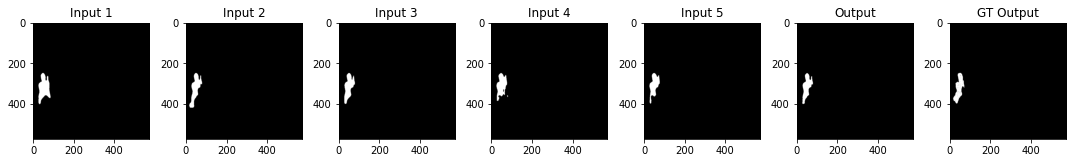

Max Value:  1  Min Value:  0
[37,  6000] loss: 0.320065
torch.Size([1, 572, 572])


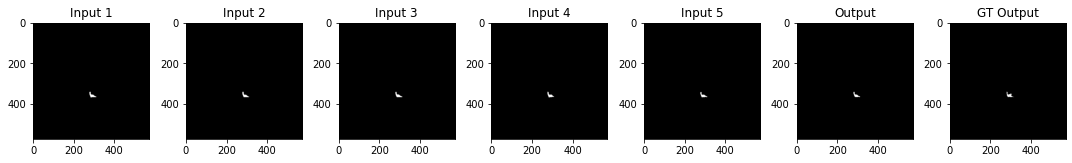

Max Value:  1  Min Value:  0
[37,  8000] loss: 0.320546
torch.Size([1, 572, 572])


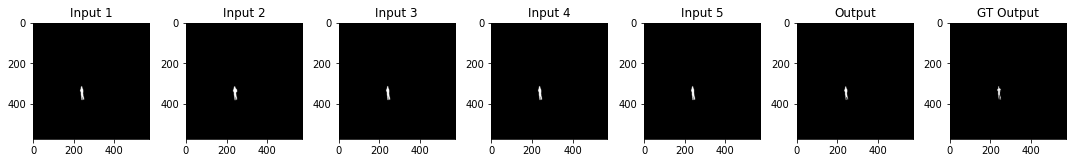

Max Value:  1  Min Value:  0
[38,  2000] loss: 0.320179
torch.Size([1, 572, 572])


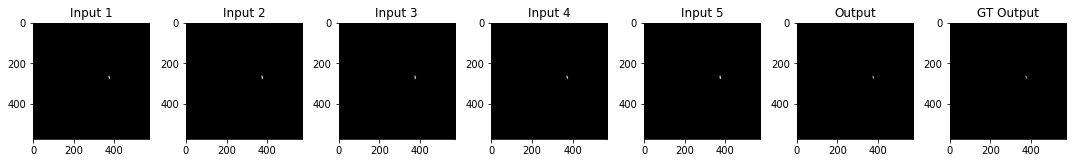

Max Value:  1  Min Value:  0
[38,  4000] loss: 0.319888
torch.Size([1, 572, 572])


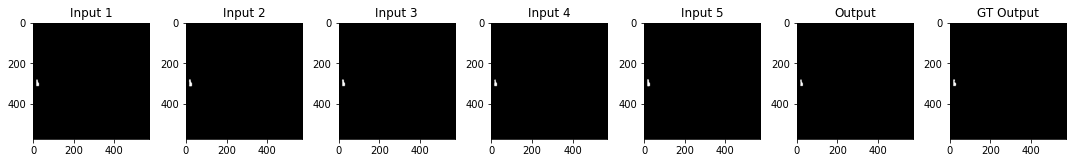

Max Value:  1  Min Value:  0
[38,  6000] loss: 0.320557
torch.Size([1, 572, 572])


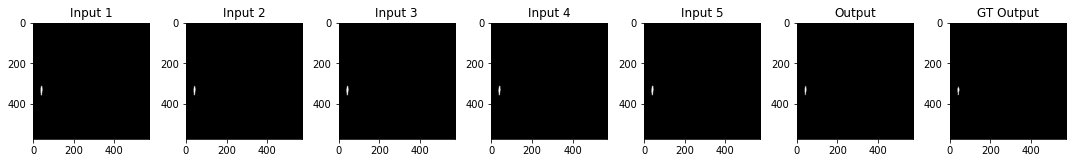

Max Value:  1  Min Value:  0
[38,  8000] loss: 0.320239
torch.Size([1, 572, 572])


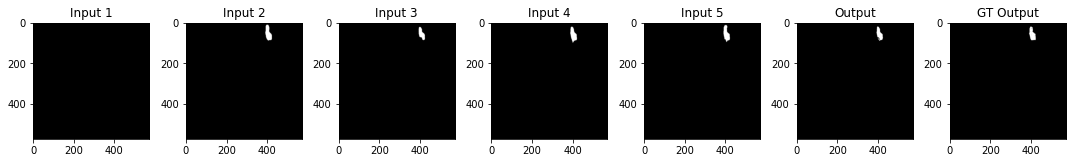

Max Value:  1  Min Value:  0
[39,  2000] loss: 0.320146
torch.Size([1, 572, 572])


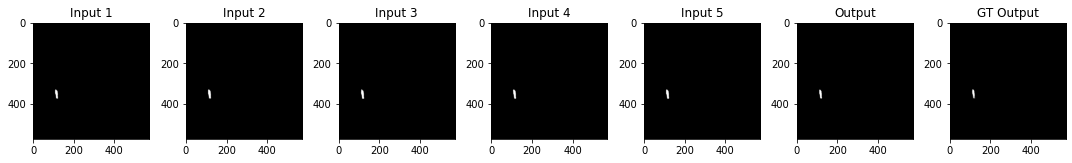

Max Value:  1  Min Value:  0
[39,  4000] loss: 0.320589
torch.Size([1, 572, 572])


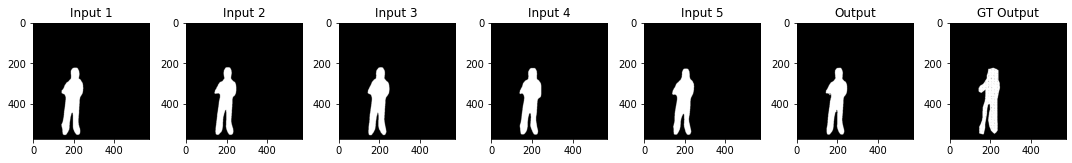

Max Value:  1  Min Value:  0
[39,  6000] loss: 0.320037
torch.Size([1, 572, 572])


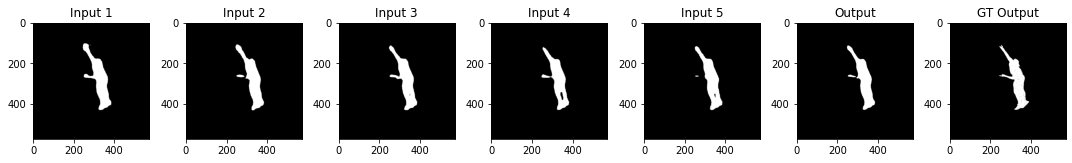

Max Value:  1  Min Value:  0
[39,  8000] loss: 0.320115
torch.Size([1, 572, 572])


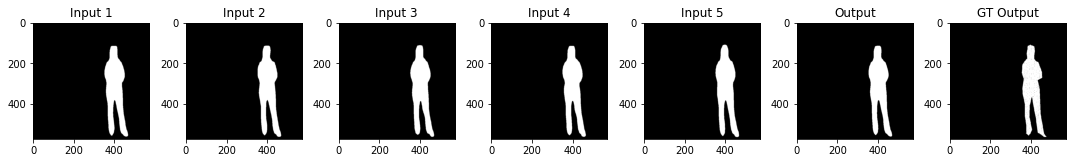

Max Value:  1  Min Value:  0
[40,  2000] loss: 0.320723
torch.Size([1, 572, 572])


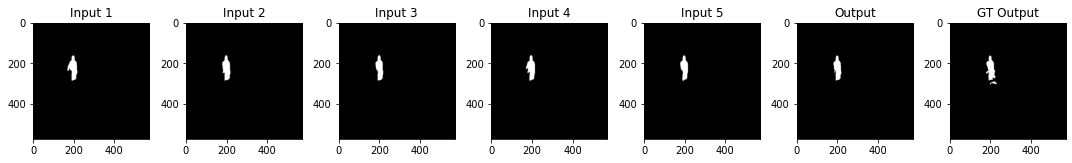

Max Value:  1  Min Value:  0
[40,  4000] loss: 0.319915
torch.Size([1, 572, 572])


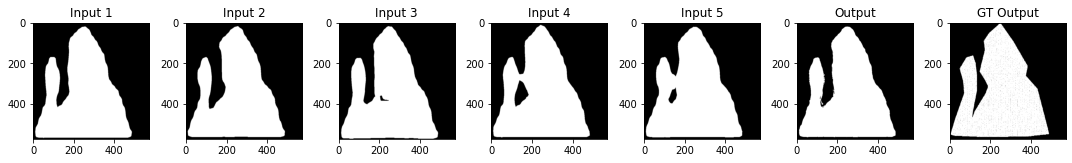

Max Value:  1  Min Value:  0
[40,  6000] loss: 0.320307
torch.Size([1, 572, 572])


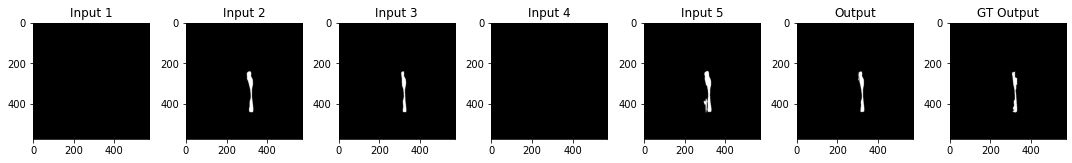

Max Value:  1  Min Value:  0
[40,  8000] loss: 0.320151
torch.Size([1, 572, 572])


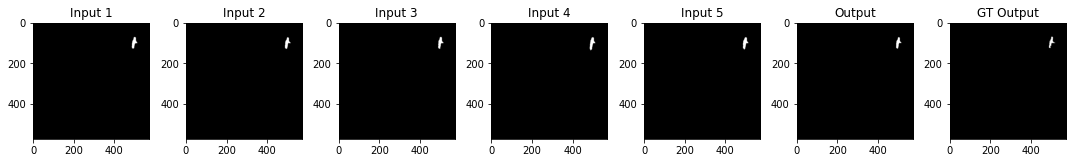

Max Value:  1  Min Value:  0
[41,  2000] loss: 0.320306
torch.Size([1, 572, 572])


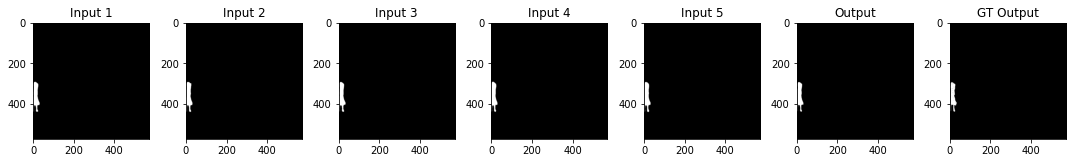

Max Value:  1  Min Value:  0
[41,  4000] loss: 0.319674
torch.Size([1, 572, 572])


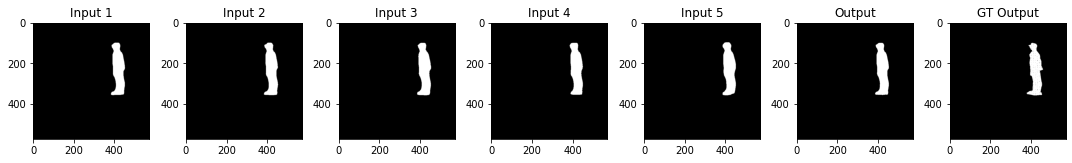

Max Value:  1  Min Value:  0
[41,  6000] loss: 0.320346
torch.Size([1, 572, 572])


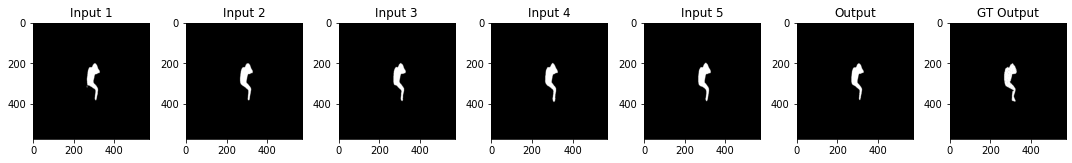

Max Value:  1  Min Value:  0
[41,  8000] loss: 0.320650
torch.Size([1, 572, 572])


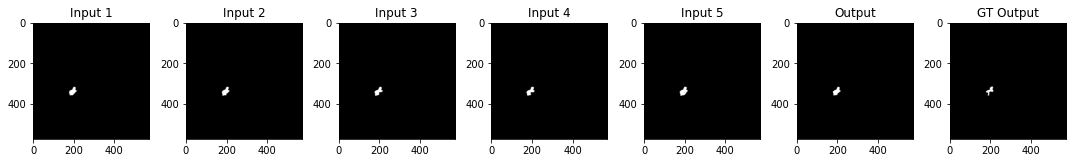

Max Value:  1  Min Value:  0
[42,  2000] loss: 0.319618
torch.Size([1, 572, 572])


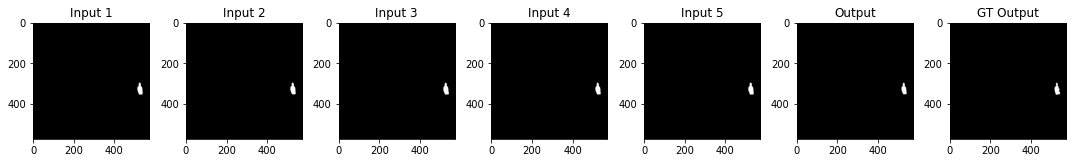

Max Value:  1  Min Value:  0
[42,  4000] loss: 0.320522
torch.Size([1, 572, 572])


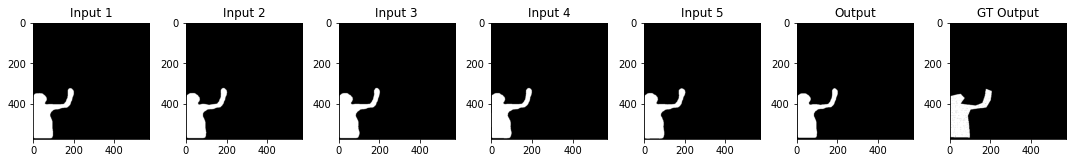

Max Value:  1  Min Value:  0
[42,  6000] loss: 0.320547
torch.Size([1, 572, 572])


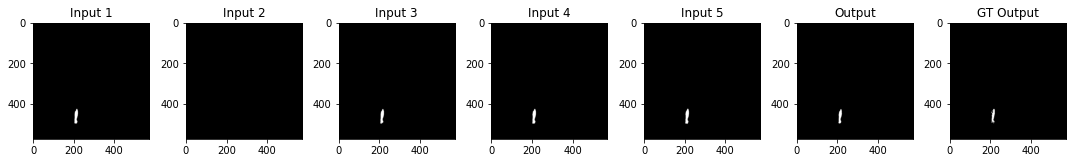

Max Value:  1  Min Value:  0
[42,  8000] loss: 0.320136
torch.Size([1, 572, 572])


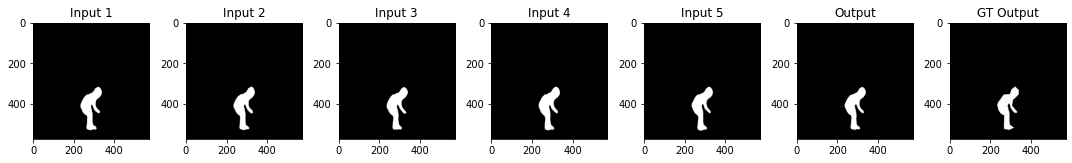

Max Value:  1  Min Value:  0
[43,  2000] loss: 0.319956
torch.Size([1, 572, 572])


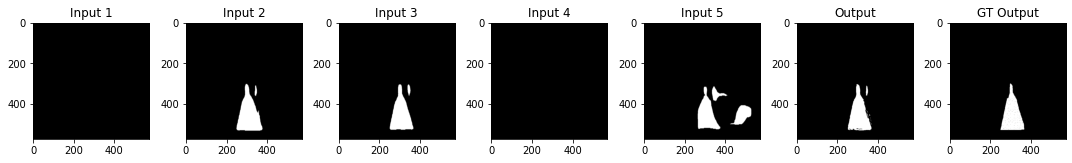

Max Value:  1  Min Value:  0
[43,  4000] loss: 0.320163
torch.Size([1, 572, 572])


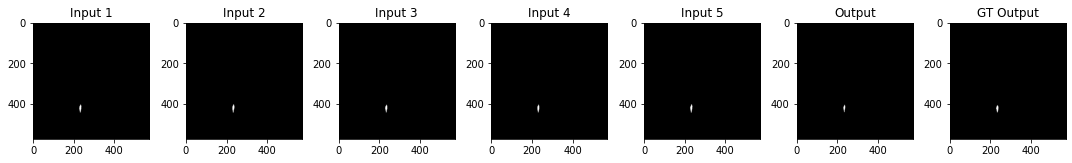

Max Value:  1  Min Value:  0
[43,  6000] loss: 0.320386
torch.Size([1, 572, 572])


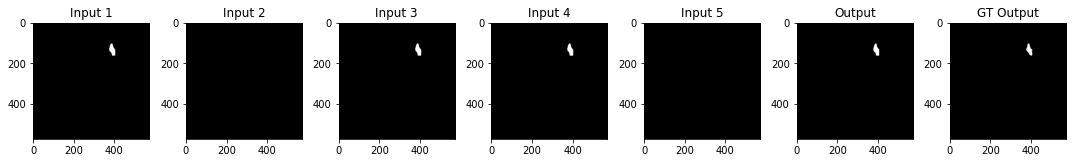

Max Value:  1  Min Value:  0
[43,  8000] loss: 0.320347
torch.Size([1, 572, 572])


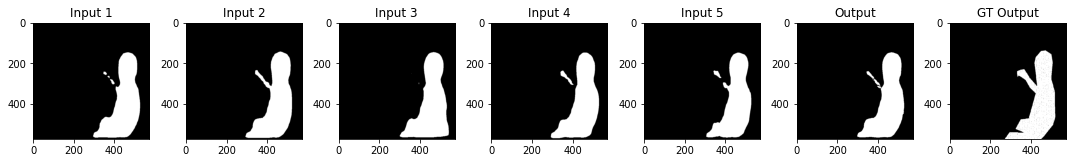

Max Value:  1  Min Value:  0
[44,  2000] loss: 0.320088
torch.Size([1, 572, 572])


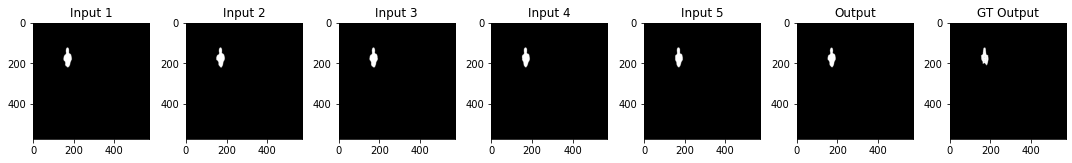

Max Value:  1  Min Value:  0
[44,  4000] loss: 0.320122
torch.Size([1, 572, 572])


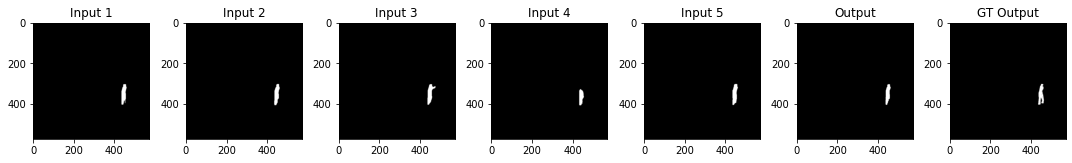

Max Value:  1  Min Value:  0
[44,  6000] loss: 0.319985
torch.Size([1, 572, 572])


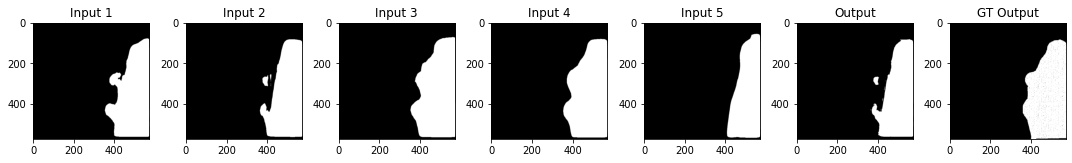

Max Value:  1  Min Value:  0
[44,  8000] loss: 0.320521
torch.Size([1, 572, 572])


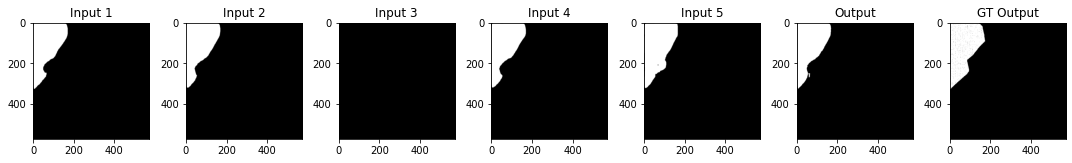

Max Value:  1  Min Value:  0
[45,  2000] loss: 0.320292
torch.Size([1, 572, 572])


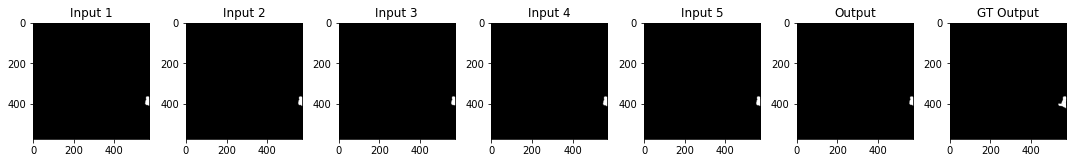

Max Value:  1  Min Value:  0
[45,  4000] loss: 0.320716
torch.Size([1, 572, 572])


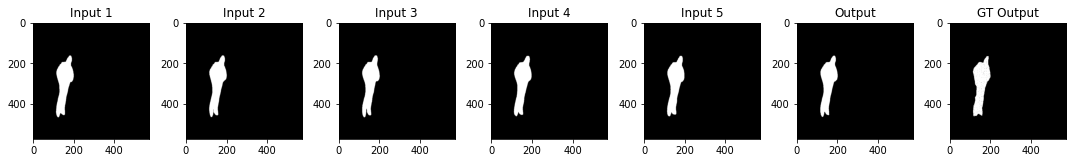

Max Value:  1  Min Value:  0
[45,  6000] loss: 0.319992
torch.Size([1, 572, 572])


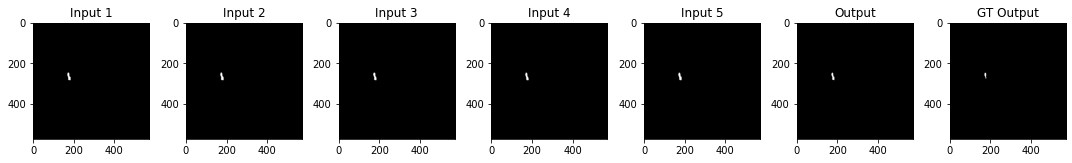

Max Value:  1  Min Value:  0
[45,  8000] loss: 0.319736
torch.Size([1, 572, 572])


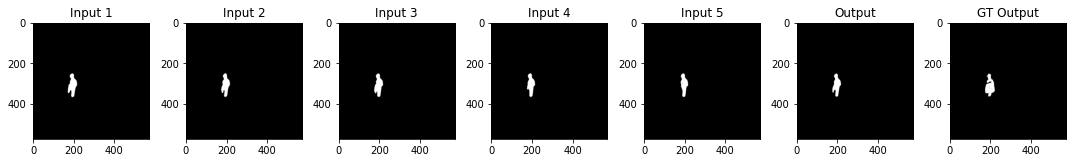

Max Value:  1  Min Value:  0
[46,  2000] loss: 0.320690
torch.Size([1, 572, 572])


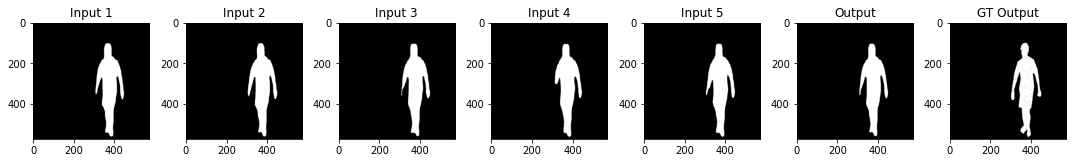

Max Value:  1  Min Value:  0
[46,  4000] loss: 0.319685
torch.Size([1, 572, 572])


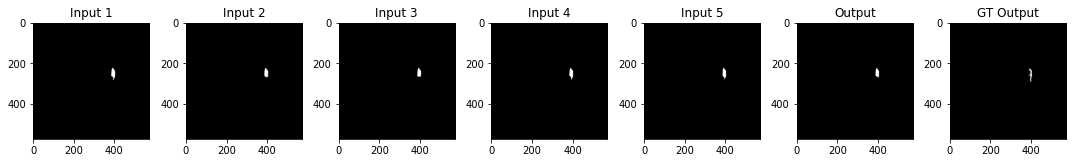

Max Value:  1  Min Value:  0
[46,  6000] loss: 0.319793
torch.Size([1, 572, 572])


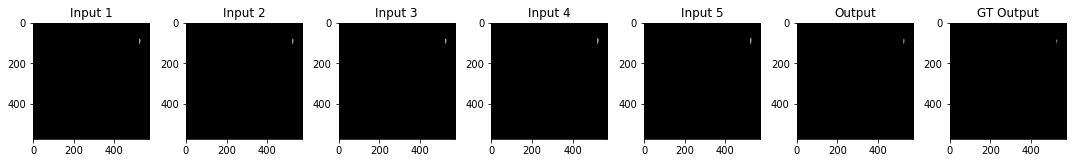

Max Value:  1  Min Value:  0
[46,  8000] loss: 0.320339
torch.Size([1, 572, 572])


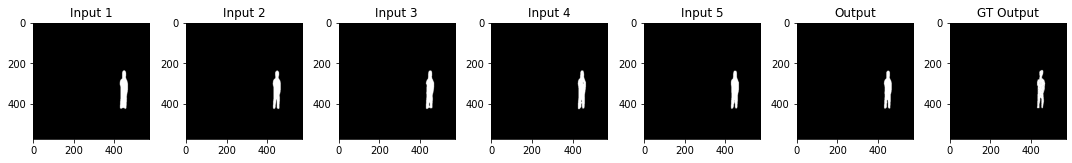

Max Value:  1  Min Value:  0
[47,  2000] loss: 0.320146
torch.Size([1, 572, 572])


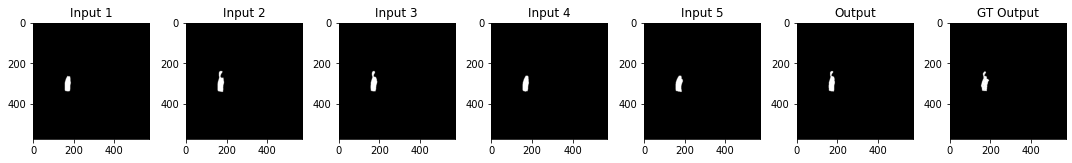

Max Value:  1  Min Value:  0
[47,  4000] loss: 0.321036
torch.Size([1, 572, 572])


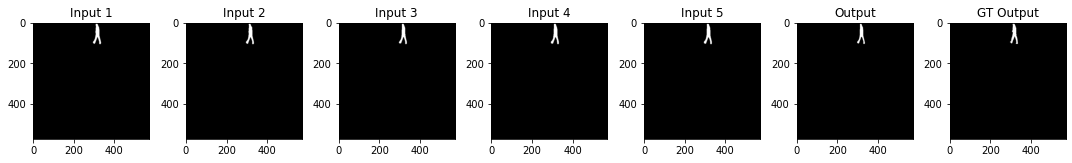

Max Value:  1  Min Value:  0
[47,  6000] loss: 0.319543
torch.Size([1, 572, 572])


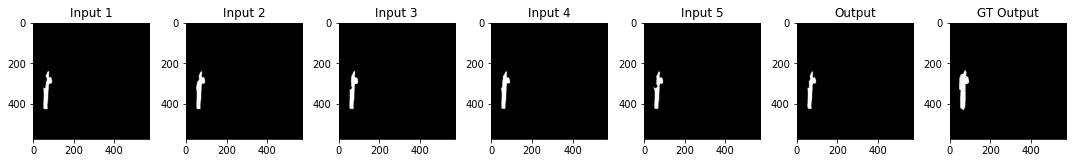

Max Value:  1  Min Value:  0
[47,  8000] loss: 0.319980
torch.Size([1, 572, 572])


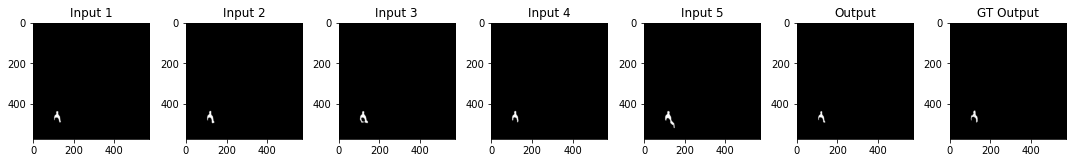

Max Value:  1  Min Value:  0
[48,  2000] loss: 0.320201
torch.Size([1, 572, 572])


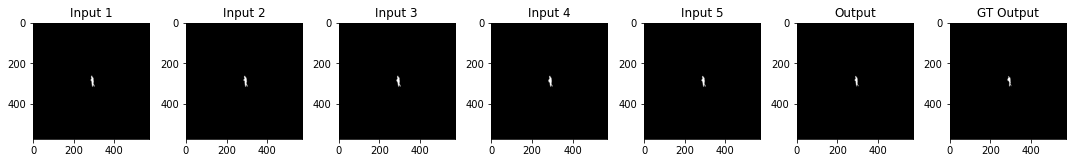

Max Value:  1  Min Value:  0
[48,  4000] loss: 0.320119
torch.Size([1, 572, 572])


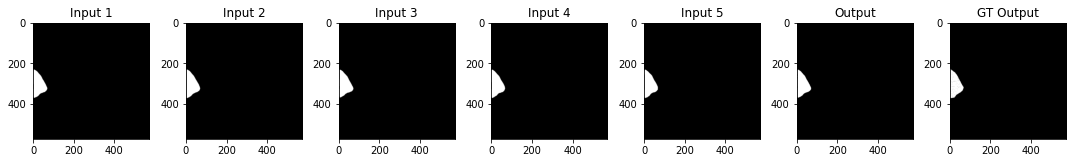

Max Value:  1  Min Value:  0
[48,  6000] loss: 0.320406
torch.Size([1, 572, 572])


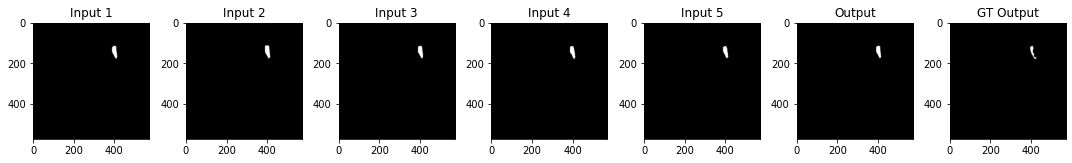

Max Value:  1  Min Value:  0
[48,  8000] loss: 0.319979
torch.Size([1, 572, 572])


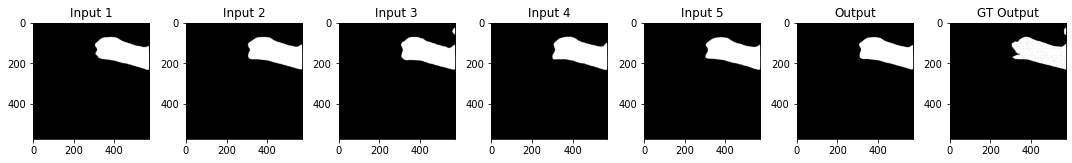

Max Value:  1  Min Value:  0
[49,  2000] loss: 0.320054
torch.Size([1, 572, 572])


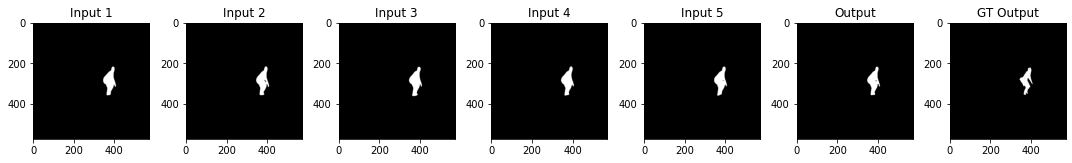

Max Value:  1  Min Value:  0
[49,  4000] loss: 0.320268
torch.Size([1, 572, 572])


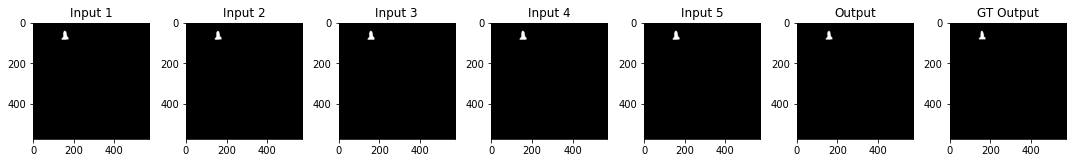

Max Value:  1  Min Value:  0
[49,  6000] loss: 0.320714
torch.Size([1, 572, 572])


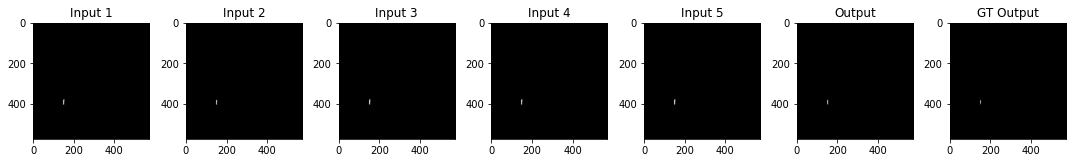

Max Value:  1  Min Value:  0
[49,  8000] loss: 0.319682
torch.Size([1, 572, 572])


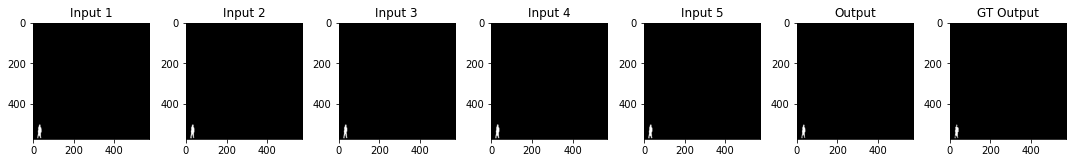

Max Value:  1  Min Value:  0
[50,  2000] loss: 0.321030
torch.Size([1, 572, 572])


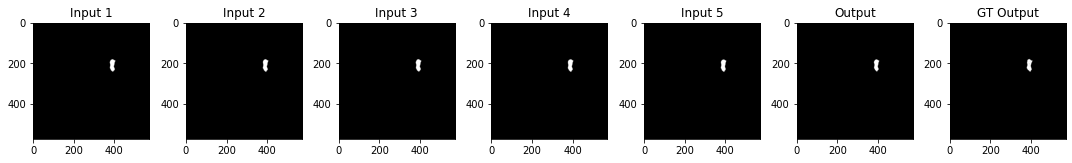

Max Value:  1  Min Value:  0
[50,  4000] loss: 0.319834
torch.Size([1, 572, 572])


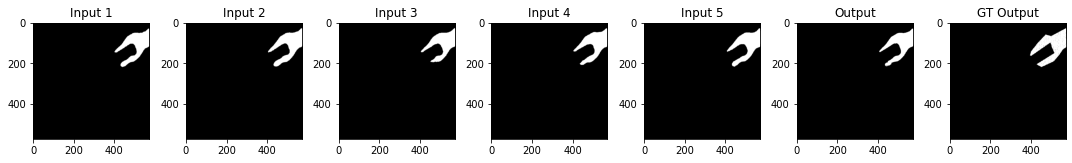

Max Value:  1  Min Value:  0
[50,  6000] loss: 0.319943
torch.Size([1, 572, 572])


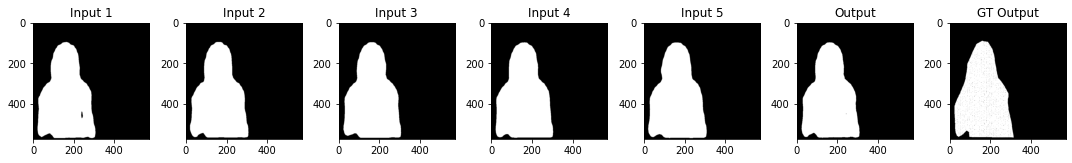

Max Value:  1  Min Value:  0
[50,  8000] loss: 0.319953
torch.Size([1, 572, 572])


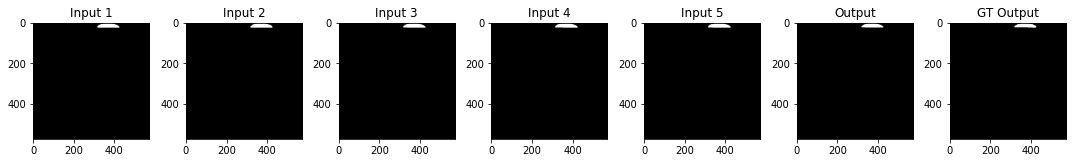

Max Value:  1  Min Value:  0
Finished Training


In [12]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
OPTIMIZER = "SGD"
ACTIVATION = "lrelu"
LOSS = "CrossEntropyLoss"

for layers in [[(3,5,16),(3,16,32),(5,32,64),(5,64,32),(3,32,16),(3,16,2)]]:
    print("Starting training on network ",layers)
    
    net = SimpleNet(layers,activation=ACTIVATION)
    net = net.to(device).float()
    
    if LOSS == "BCELoss":
        criterion = nn.BCELoss()
    elif LOSS == "CrossEntropyLoss":
        criterion = nn.CrossEntropyLoss()
        
    criterion_class = nn.NLLLoss()
        
    if OPTIMIZER == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif OPTIMIZER == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    checkpoint_path = "work_dirs/simplenet"
    for layer in layers:
        checkpoint_path += "_"+str(layer)
    checkpoint_path += "/" + OPTIMIZER + "_" + ACTIVATION + "_" + LOSS + "/"
    tensorboard_path = checkpoint_path+"tb/"
    os.makedirs(tensorboard_path,exist_ok=True)
    
    train(net,trainloader,criterion,optimizer, checkpoint_path, tensorboard_path)#, checkpoint="work_dirs/simplenet_1/epoch_25.pt")

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
event_acc = EventAccumulator('work_dirs/simplenet_1_1_1/sigmoid_BCELoss/tb')
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

# E. g. get wall clock, number of steps and value for a scalar 'Accuracy'
w_times, step_nums, vals = zip(*event_acc.Scalars('Loss'))

# Network Summary

In [ ]:
# for i in range(1):
    data = trainset[i]
    
    im_seg = data['im_seg']
    im_res = data['im_res']
    
    res = im_seg[0:3,:,:].numpy().transpose((1,2,0))
    
    fig = plt.figure()
    plt.imshow(res)